# Illinois Analysis
In this notebook, we do a deep dive into Illinois, for which we have the most feature-rich data.
We first train some basic algorithms, including KNN and Linear Regression, then we compare to that the result of XGBoost.
The features are School-level demographic data, and the targets are SAT Math scores.

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np



In [3]:
#Import that data
df19 = pd.read_csv("../data/IL19/IL19_Combined_Ed_Demographic.csv")
df20 = pd.read_csv("../data/IL20/IL20_Combined_Ed_Demographic.csv")
df21 = pd.read_csv("../data/IL21/IL21_Combined_Ed_Demographic.csv")
df22 = pd.read_csv("../data/IL22/IL22_Combined_Ed_Demographic.csv")
df23 = pd.read_csv("../data/IL23/IL23_Combined_Ed_Demographic.csv")
df19.columns

Index(['RCDTS', 'Type', 'School Name', 'District', 'City', 'County',
       'District Type', 'School Type', 'Grades Served',
       'Summative Designation', 'Summative Designation: Student Group(s)',
       'Title 1 Status', '# Student Enrollment',
       '% Student Enrollment - White',
       '% Student Enrollment - Black or African American',
       '% Student Enrollment - Hispanic or Latino',
       '% Student Enrollment - Asian',
       '% Student Enrollment - Native Hawaiian or Other Pacific Islander',
       '% Student Enrollment - American Indian or Alaska Native',
       '% Student Enrollment - Two or More Races',
       '% Student Enrollment - Children with Disabilities',
       '% Student Enrollment - EL', '% Student Enrollment - IEP',
       '% Student Enrollment - Low Income', '% Student Enrollment - Homeless',
       'Total Number of School Days', 'Student Attendance Rate',
       'Student Chronic Truancy Rate', 'High School Dropout Rate - Total',
       'Avg Class Size - 

In [107]:
df_combined = pd.concat([df19,
                         df20,
                         df21,
                         df22,
                         df23],ignore_index=True)

# Remove duplicates (if duplicate rows aren't necessary)
df_combined = df_combined.drop_duplicates(subset=['School Name', 'Year'])
df_combined = df_combined.dropna(subset=['SAT Math Average'])



# First, make sure it's numeric (in case you've got leftover '*' entries too)
df_combined['SAT Math Average'] = pd.to_numeric(df_combined['SAT Math Average'], errors='coerce')

# Now drop rows where it's 0 or NaN
df_combined = df_combined[df_combined['SAT Math Average'] > 0]


dfs = [df19,df20,df21,df22,df23]
dfs = [df[df['SAT Math Average'] > 0].dropna(subset=["SAT Math Average"]) for df in dfs]
df19, df20, df21, df22, df23 = dfs

    


## Exploratory Data Analysis
Let's do some initial looks at our data

/tmp/ipykernel_140483/2918765090.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


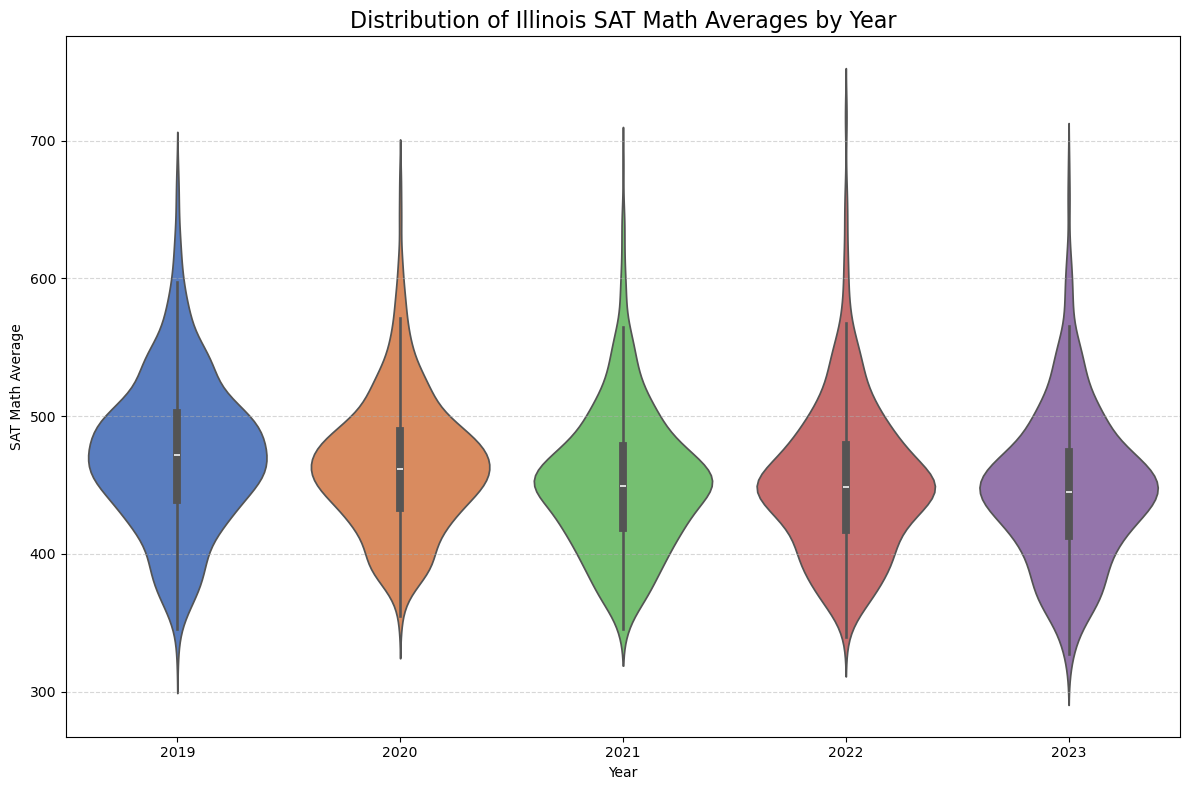

In [108]:
# Make sure 'Year' is treated as categorical for proper spacing
df_combined['Year'] = df_combined['Year'].astype(str)

plt.figure(figsize=(12, 8))
sns.violinplot(
    data=df_combined,
    x='Year',
    y='SAT Math Average',
    inner='box',         # Show a mini boxplot inside each violin
    palette='muted'
)

plt.title('Distribution of Illinois SAT Math Averages by Year', fontsize=16)
plt.xlabel('Year')
plt.ylabel('SAT Math Average')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

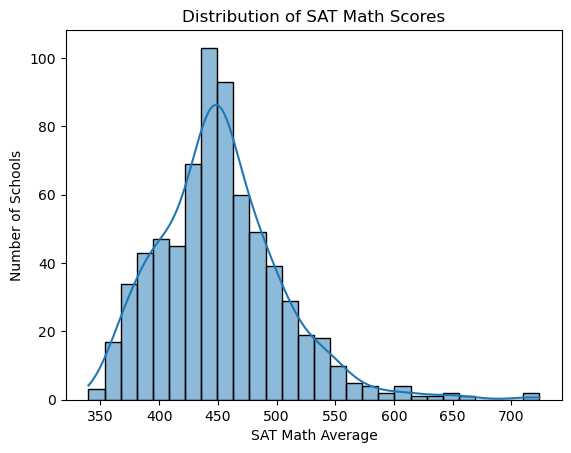

In [6]:
sns.histplot(df22['SAT Math Average'], kde=True)
plt.title("Distribution of SAT Math Scores")
plt.xlabel("SAT Math Average")
plt.ylabel("Number of Schools")
plt.show()

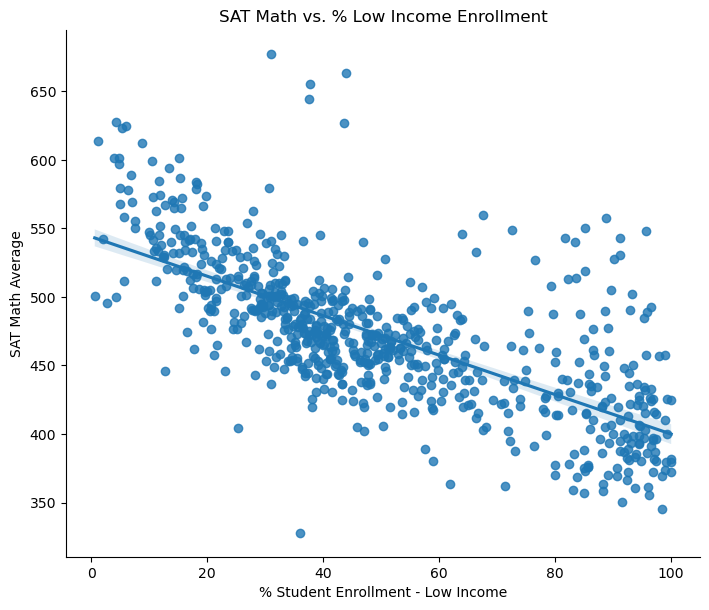

In [7]:
sns.lmplot(data=df19, x='% Student Enrollment - Low Income', y='SAT Math Average', height=6, aspect=1.2)
plt.title("SAT Math vs. % Low Income Enrollment")
plt.show()


/tmp/ipykernel_140483/2265021928.py:26: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


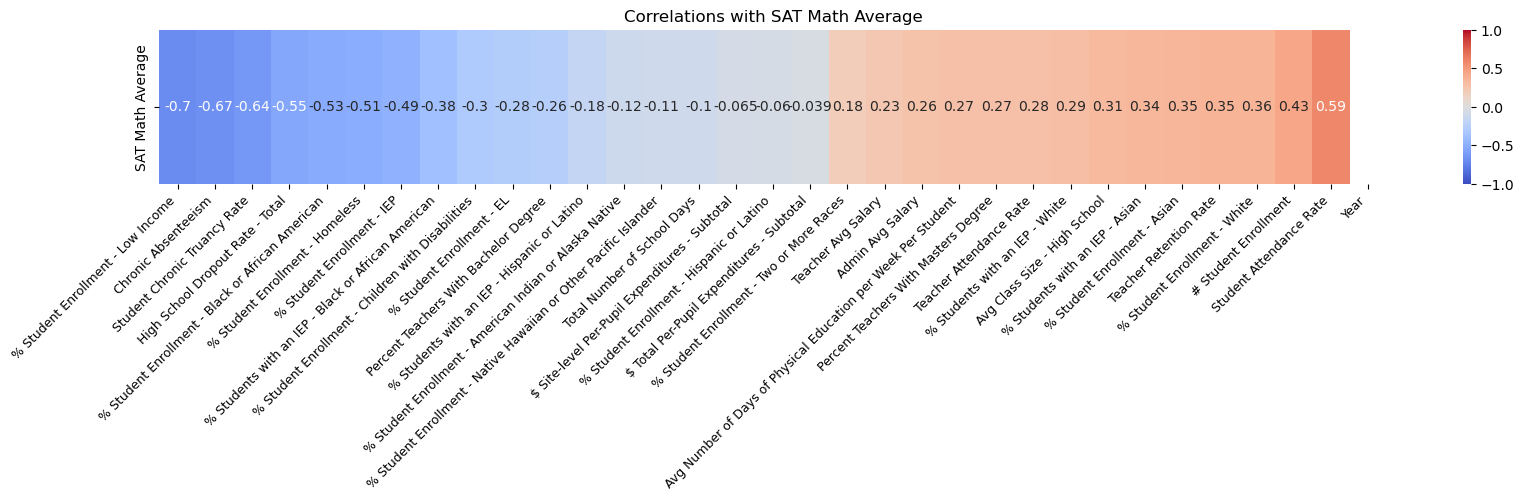

In [105]:
# Filter to numeric columns
numeric_cols = df19.select_dtypes(include=[np.number])

# Drop columns containing "SAT" in the name
filtered_cols = [col for col in numeric_cols.columns if "SAT" not in col]

# Compute correlations with SAT Math Average (using filtered columns)
corr = df19[filtered_cols + ['SAT Math Average']].corr()

# Sort correlations
sorted_corr = corr[['SAT Math Average']].drop('SAT Math Average').sort_values(by='SAT Math Average', ascending=True)

# Transpose for horizontal orientation
sorted_corr = sorted_corr.T

# Plot horizontal heatmap
plt.figure(figsize=(len(sorted_corr.columns) * 0.6, 2))  # Dynamic width
ax = sns.heatmap(
    sorted_corr,
    annot=True, cmap='coolwarm', vmin=-1, vmax=1
)

# Set x-tick labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=9)
plt.title("Correlations with SAT Math Average")
plt.tight_layout()
plt.show()



In [9]:
corr[['SAT Math Average']].sort_values(by='SAT Math Average', ascending=False)

SAT Math Average
SAT Math Average                                            1.000000
SAT Reading Average                                         0.953051
SAT Math Total Students Level 3 %                           0.913372
SAT Math Total Students Level 4 %                           0.800795
Student Attendance Rate                                     0.585046
# Student Enrollment                                        0.433518
% Student Enrollment - White                                0.357430
Teacher Retention Rate                                      0.352187
% Student Enrollment - Asian                                0.350330
% Students with an IEP - Asian                              0.339912
Avg Class Size - High School                                0.314914
% Students with an IEP - White                              0.289475
Teacher Attendance Rate                                     0.277775
Percent Teachers With Masters Degree                        0.274850
Avg Number of Days of Physical Education per We...          0.274373
Admin Avg Salary                                            0.259900
Teacher Avg Salary                                          0.228928
SAT Math Total Students Level 2 %                           0.205457
% Student Enrollment - Two or More Races                    0.183915
$ Total Per-Pupil Expenditures - Subtotal                  -0.039264
% Student Enrollment - Hispanic or Latino                  -0.060448
$ Site-level Per-Pupil Expenditures - Subtotal             -0.065355
Total Number of School Days                                -0.103956
% Student Enrollment - Native Hawaiian or Other...         -0.105025
% Student Enrollment - American Indian or Alask...         -0.118571
% Students with an IEP - Hispanic or Latino                -0.176223
Percent Teachers With Bachelor Degree                      -0.262255
% Student Enrollment - EL                                  -0.276530
% Student Enrollment - Children with Disabilities          -0.304040
% Students with an IEP - Black or African American         -0.383167
% Student Enrollment - IEP                                 -0.489875
% Student Enrollment - Homeless                            -0.508000
% Student Enrollment - Black or African American           -0.525944
High School Dropout Rate - Total                           -0.551280
Student Chronic Truancy Rate                               -0.636979
Chronic Absenteeism                                        -0.672660
% Student Enrollment - Low Income                          -0.700013
SAT Math Total Students Level 1 %                          -0.947935
Year                                                             NaN

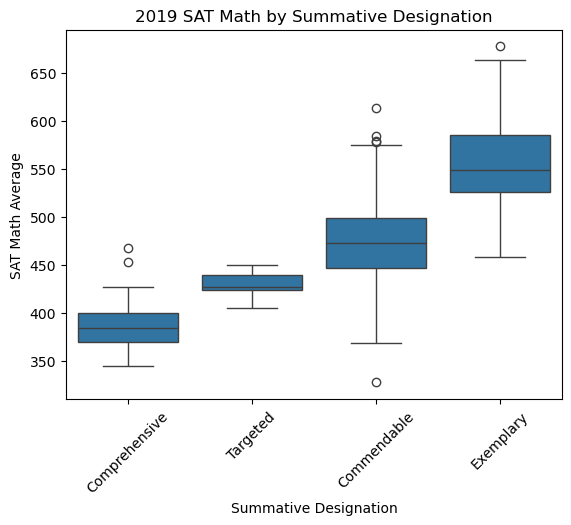

In [10]:
sns.boxplot(
    data=df19,
    x='Summative Designation',
    y='SAT Math Average',
    order=["Comprehensive", "Targeted", "Commendable", "Exemplary"]  # custom order
)
plt.xticks(rotation=45)
plt.title("2019 SAT Math by Summative Designation")
plt.show()


#### Let's make a pair plot of the most strongly correlated features with SAT math score, positive and negative

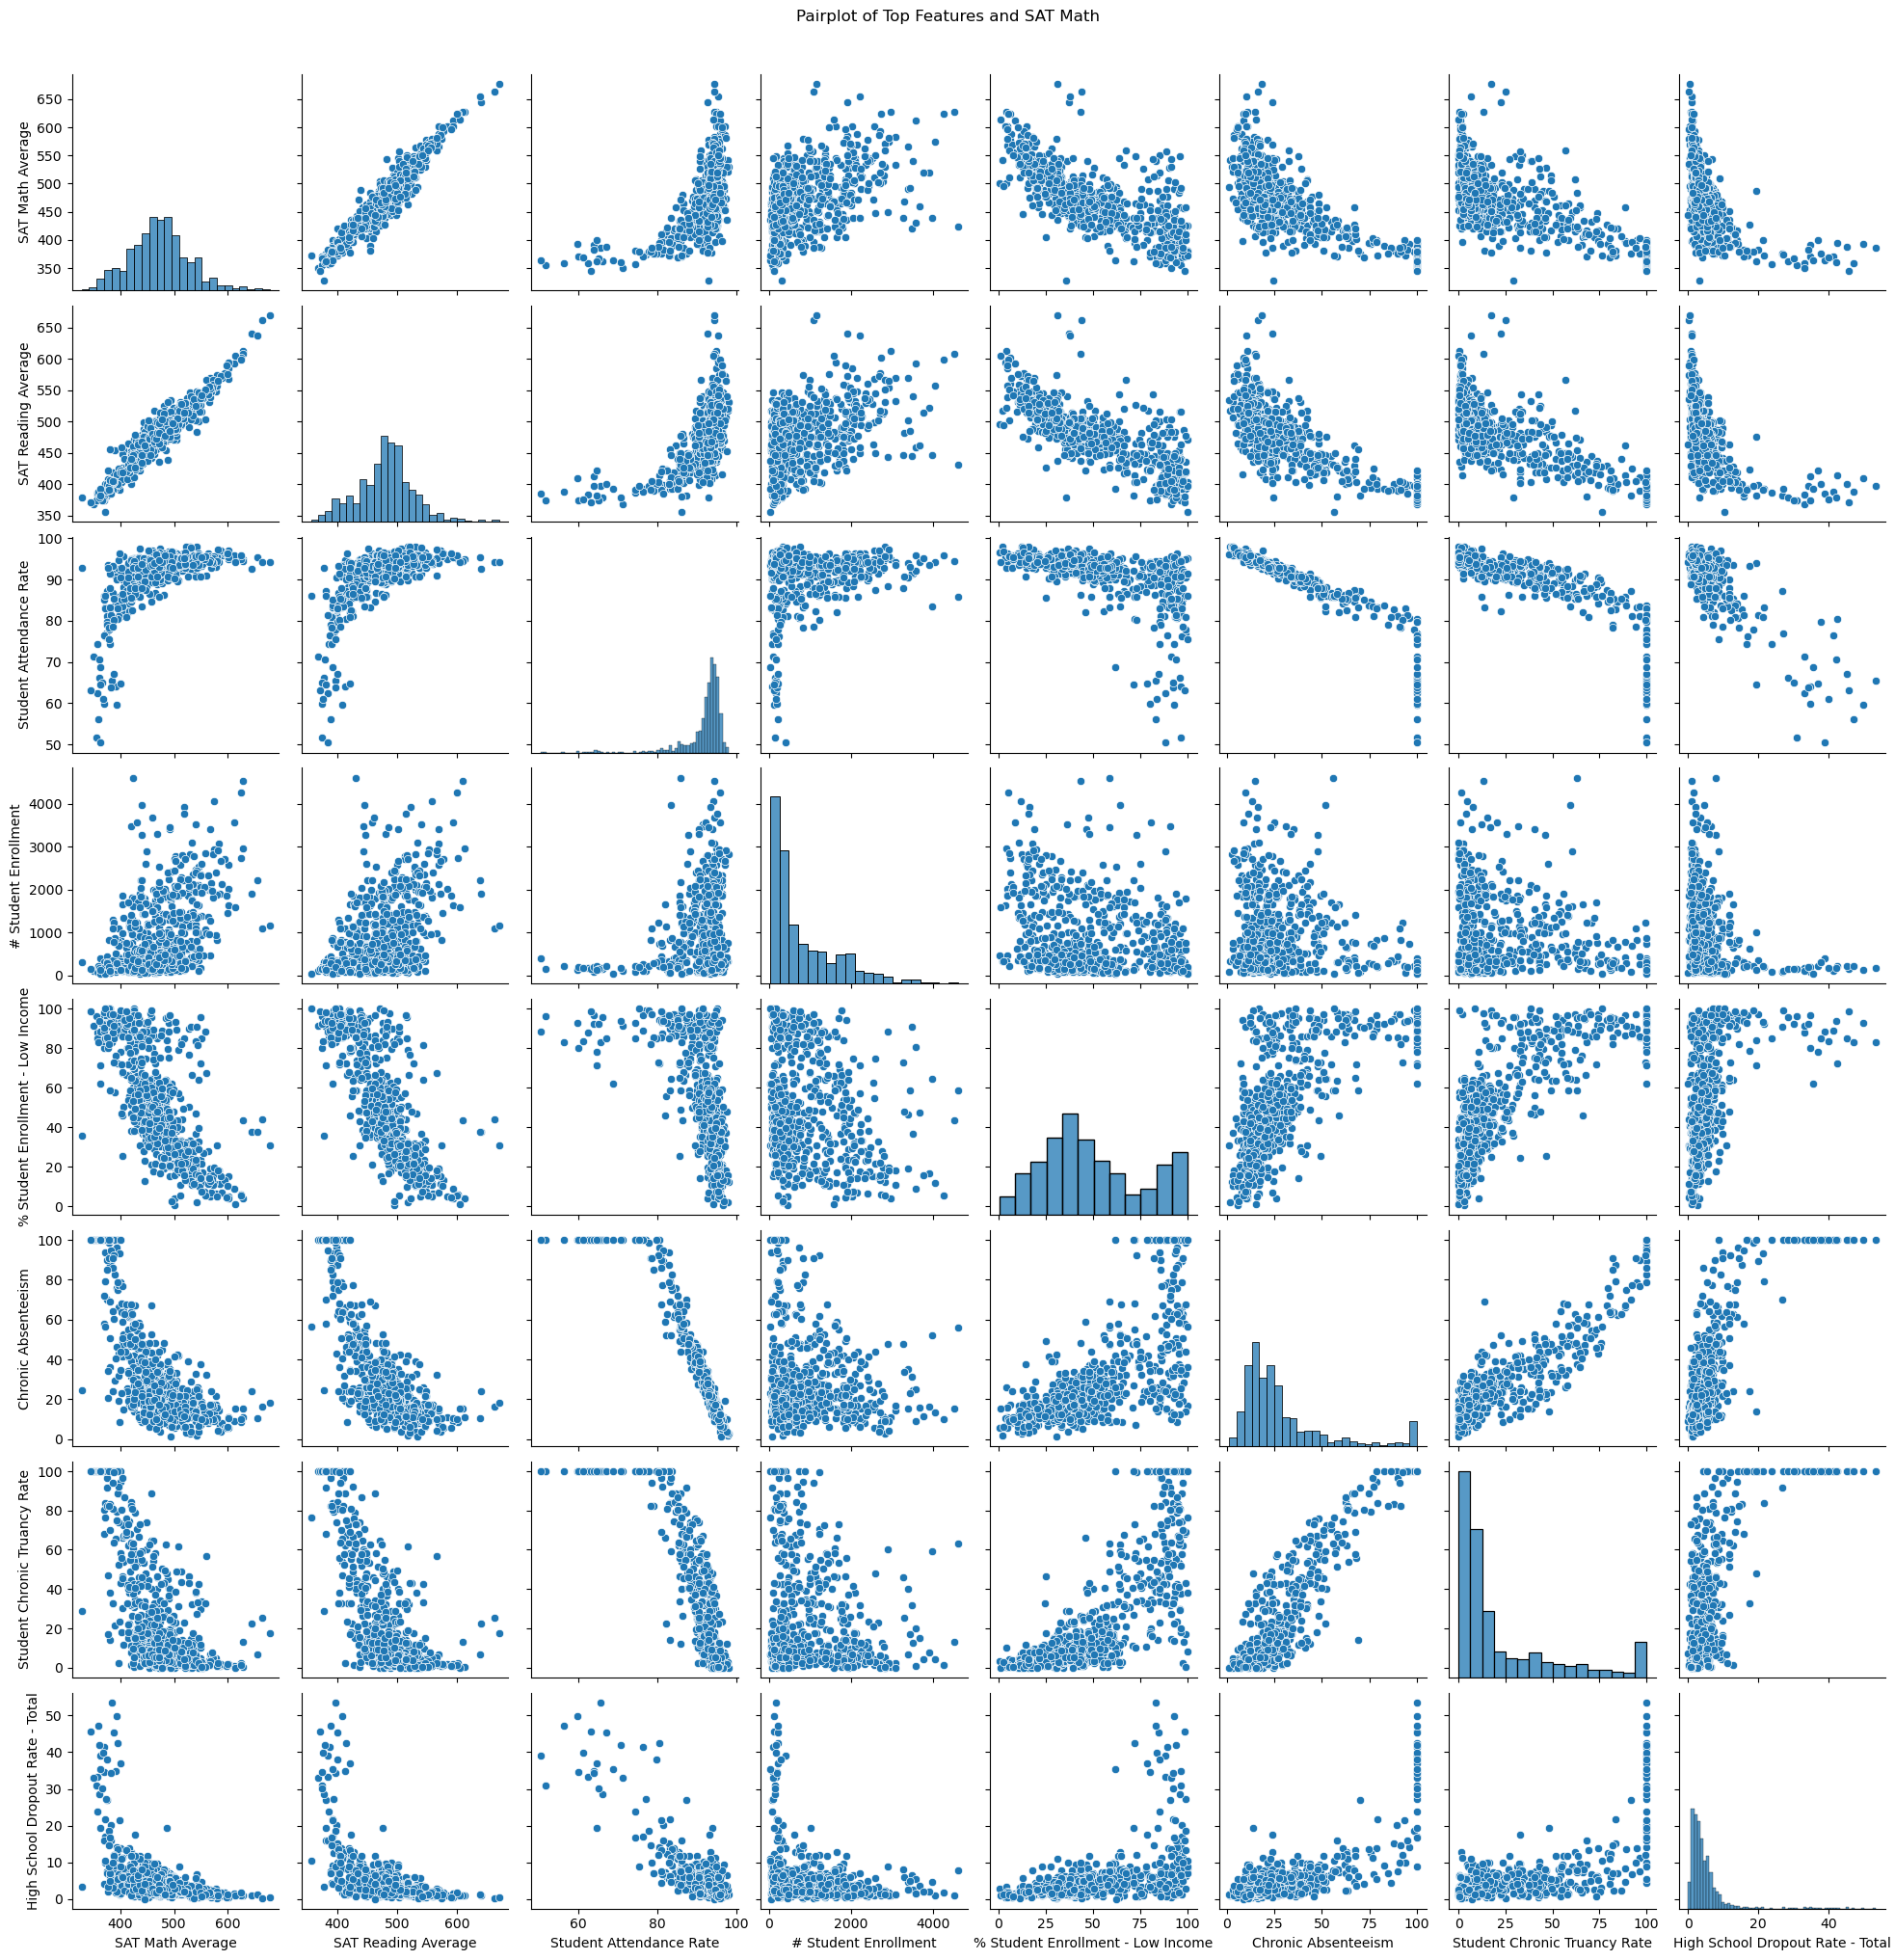

In [11]:
# Sort the correlation values with SAT Math Average
sorted_corr = corr[['SAT Math Average']].sort_values(by='SAT Math Average', ascending=False)

# Get top and bottom features by their index labels (i.e., feature names)
top_features = sorted_corr.iloc[[0, 1, 4, 5]].index.tolist()
bottom_features = sorted_corr.iloc[[-3, -4, -5, -6]].index.tolist()

# Combine them into one list
top_feats = top_features + bottom_features

sns.pairplot(df19[top_feats].dropna())
plt.suptitle("Pairplot of Top Features and SAT Math", y=1.02)
plt.show()

#### What about money spent per pupil at a school? Any correlation?

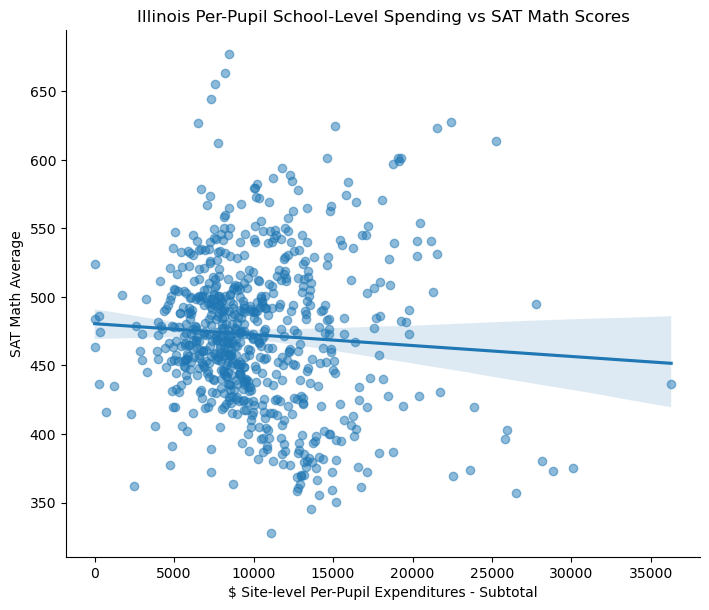

In [109]:
sns.lmplot(
    data=df19,
    x='$ Site-level Per-Pupil Expenditures - Subtotal',
    y='SAT Math Average',
    height=6,
    aspect=1.2,
    scatter_kws={'alpha': 0.5}
)
plt.title("Illinois Per-Pupil School-Level Spending vs SAT Math Scores")
plt.show()


#### Surprising! Seemingly no correlation at all! What if we color code points by % of low income students?

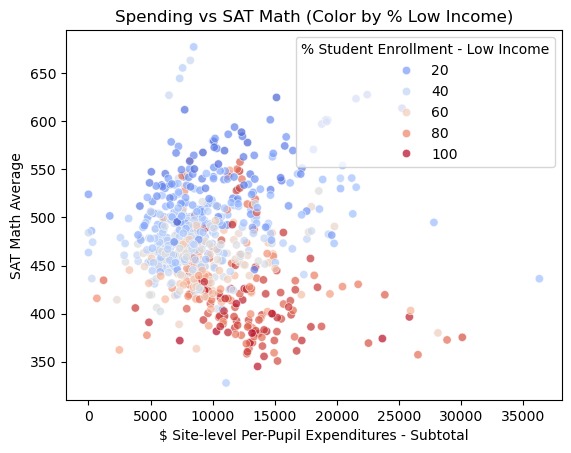

In [13]:
sns.scatterplot(
    data=df19,
    x='$ Site-level Per-Pupil Expenditures - Subtotal',
    y='SAT Math Average',
    hue='% Student Enrollment - Low Income',
    palette='coolwarm',
    alpha=0.7
)
plt.title("Spending vs SAT Math (Color by % Low Income)")
plt.show()


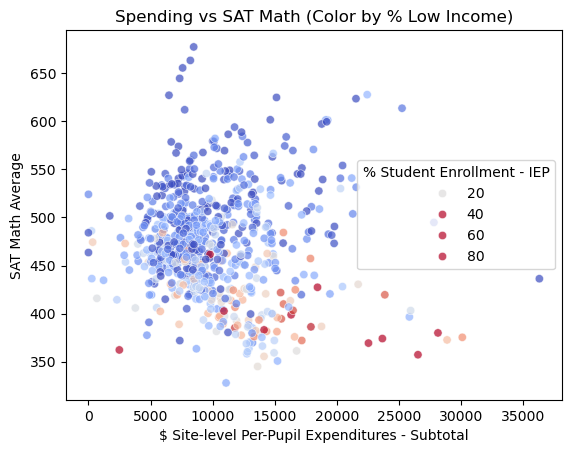

In [14]:
sns.scatterplot(
    data=df19,
    x='$ Site-level Per-Pupil Expenditures - Subtotal',
    y='SAT Math Average',
    hue='% Student Enrollment - IEP',
    palette='coolwarm',
    hue_norm=(10, 30),  # Adjust based on your data distribution
    alpha=0.7
)
plt.title("Spending vs SAT Math (Color by % Low Income)")
plt.show()



#### Interestingly, for higher income students, it seems more per pupil spending is positively correlated with SAT scores. But for low income students, this is not the case. More spending might even be negatively correlated with SAT scores, but this might be because for low income schools, more spending is correlated with a higher special education population (% IEP Enrollment)

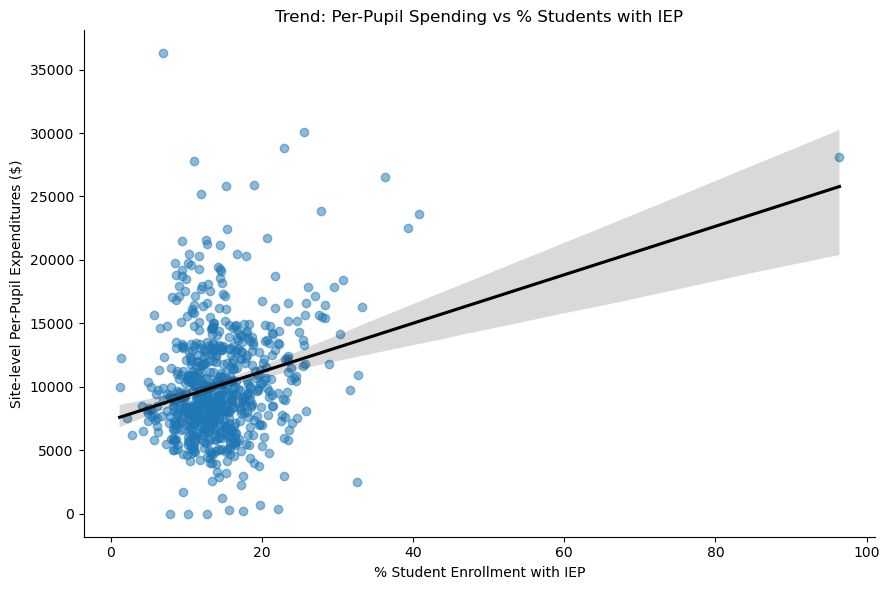

In [15]:
sns.lmplot(
    data=df19,
    y='$ Site-level Per-Pupil Expenditures - Subtotal',
    x='% Student Enrollment - IEP',
    scatter_kws={'alpha': 0.5},
    line_kws={'color': 'black'},
    height=6,
    aspect=1.5
)
plt.title("Trend: Per-Pupil Spending vs % Students with IEP")
plt.ylabel("Site-level Per-Pupil Expenditures ($)")
plt.xlabel("% Student Enrollment with IEP")
plt.tight_layout()
plt.show()


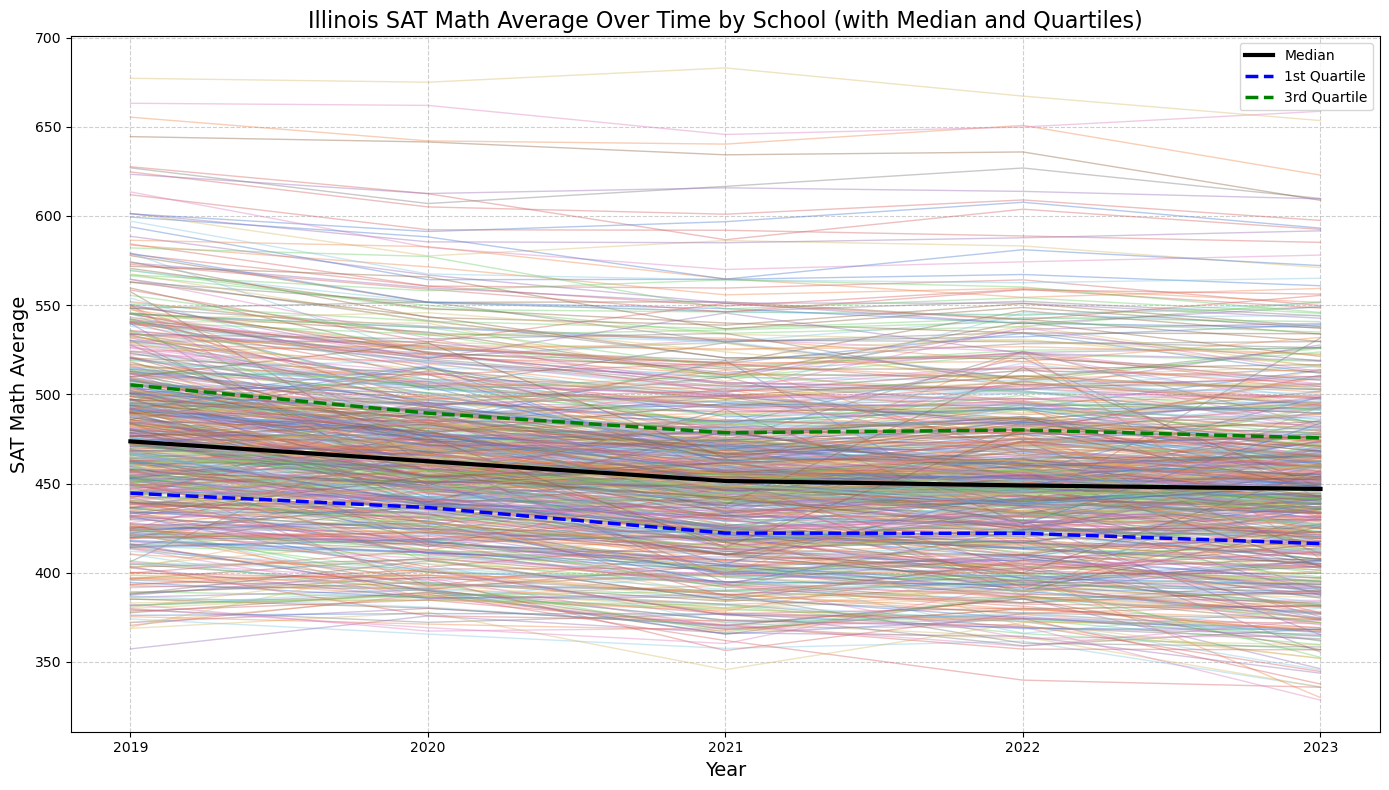

In [111]:
# Remove duplicates (if duplicate rows aren't necessary)
df_combined = df_combined.groupby(['RCDTS', 'Year'], as_index=False).agg({'SAT Math Average': 'mean'})

#Find only those schools for which we have data from each year
all_years = sorted(df_combined['Year'].unique())
year_counts = df_combined['RCDTS'].value_counts()
complete_schools = year_counts[year_counts == len(all_years)].index

# Keep only those rows
df_filtered = df_combined[df_combined['RCDTS'].isin(complete_schools)]


#Make Sphagghetti Plot
plt.figure(figsize=(14, 8))
sns.lineplot(
    data=df_filtered,
    x='Year',
    y='SAT Math Average',
    hue='RCDTS',
    palette='muted',
    linewidth=1,
    alpha=0.4,
    legend=False
)

# Step 2: Compute summary stats for each year
summary_stats = df_filtered.groupby('Year')['SAT Math Average'].agg(['median', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)]).reset_index()
summary_stats.columns = ['Year', 'Median', 'Q1', 'Q3']

# Step 3: Overlay bold lines
plt.plot(summary_stats['Year'], summary_stats['Median'], color='black', linewidth=3, label='Median')
plt.plot(summary_stats['Year'], summary_stats['Q1'], color='blue', linewidth=2.5, linestyle='--', label='1st Quartile')
plt.plot(summary_stats['Year'], summary_stats['Q3'], color='green', linewidth=2.5, linestyle='--', label='3rd Quartile')

# Final styling
plt.title('Illinois SAT Math Average Over Time by School (with Median and Quartiles)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('SAT Math Average', fontsize=14)
plt.xticks(summary_stats['Year'])
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()



In [17]:
#Clear some variables out of namespace
del df_combined
del df_filtered

# Model Training

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV

# Define most important features (maybe!)
selected_features = [
    'Student Attendance Rate',
    'Teacher Retention Rate',
    '% Student Enrollment - Asian',
    '# Student Enrollment',
    'Percent Teachers With Masters Degree',
    'Admin Avg Salary',
    'Teacher Avg Salary',
    'Teacher Attendance Rate',
    '% Student Enrollment - White',
    '% Student Enrollment - Low Income',
    'Chronic Absenteeism',
    'High School Dropout Rate - Total',
    'Student Chronic Truancy Rate',
    '% Student Enrollment - IEP',
    '% Student Enrollment - Black or African American'
]

# List of dataframes
dfs = [df19, df20, df21, df22, df23]
train_test_splits = {}




# Loop through each DataFrame (df19, df20, etc.), fix a train test split for each year
for year, df in zip([2019, 2020, 2021, 2022, 2023], dfs):

    # Drop rows with missing values in the most important features or in the target
    df_model = df.dropna(subset=selected_features + ['SAT Math Average'])
    
    # Feature matrix X and target vector y

    # Get all numeric columns that do NOT contain 'SAT' in their names
    X = df_model.select_dtypes(include=[np.number]).loc[:, ~df_model.select_dtypes(include=[np.number]).columns.str.contains('SAT')]
    y = df_model['SAT Math Average']
    
    # First: split full data into 80% train_val and 20% test
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=0.2, random_state=10
    )

    # Then: split 80% train_val into 60% train and 20% val
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=0.25, random_state=10
    )
    # (0.25 of the 80% is 20%, so the final proportions are 60/20/20)

    # Update the dictionary
    train_test_splits[year] = {
        'X_train': X_train,
        'X_val': X_val,
        'X_test': X_test,
        'y_train': y_train,
        'y_val': y_val,
        'y_test': y_test
    }
    #Clear intermediate dfs out of memory
    del [X_train_val, y_train_val]
    

In [19]:
for year in [2019, 2020, 2021, 2022, 2023]: 
    X_train = train_test_splits[year]['X_train']
    print(f"Training data size for {year}: {X_train.shape}")


Training data size for 2019: (425, 33)
Training data size for 2020: (414, 33)
Training data size for 2021: (297, 33)
Training data size for 2022: (282, 33)
Training data size for 2023: (405, 33)


#### We start with a the most naive regressor, which simply guesses the mean for each year.

In [91]:
# List to store the naive model MSE for each year
naive_RMSE = []

for year in [2019, 2020, 2021, 2022, 2023]:
    # Access the pre-defined train-test split. Note! That what we call [X_test,y_test] is actually validation set
    
    X_train = train_test_splits[year]['X_train']
    X_test = train_test_splits[year]['X_val']
    y_train = train_test_splits[year]['y_train']
    y_test = train_test_splits[year]['y_val']
    
    # Naive prediction: mean of the training targets
    y_pred_naive = [y_train.mean()] * len(y_test)
    
    # Compute MSE
    rmse_naive = root_mean_squared_error(y_test, y_pred_naive)
    naive_RMSE.append(rmse_naive)
    
    print(f"Naive Model MSE for {year}: {rmse_naive:.2f}")


Naive Model MSE for 2019: 53.05
Naive Model MSE for 2020: 45.82
Naive Model MSE for 2021: 51.44
Naive Model MSE for 2022: 55.65
Naive Model MSE for 2023: 59.10


#### Next, we train a KNN regressor for each year. We use k-fold cross validation for each year to find the best K for each year.

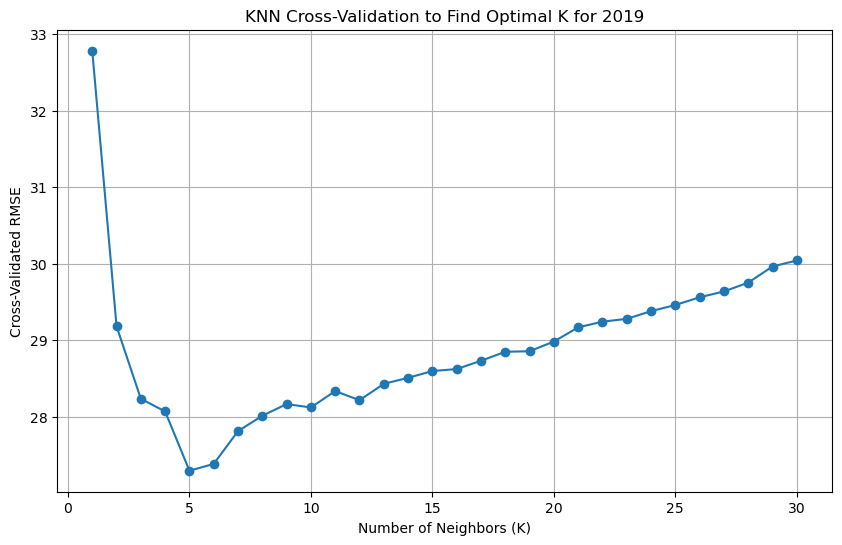

Best K value for 2019: 5 with MSE: 27.30


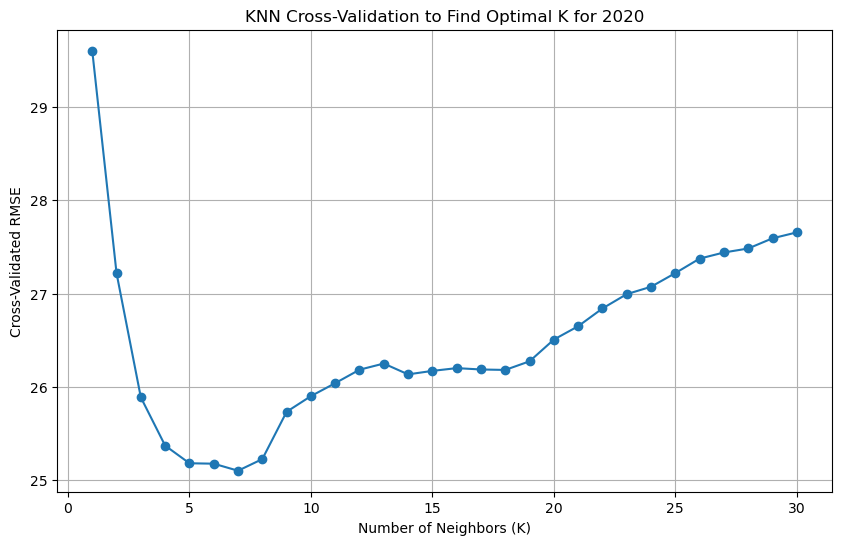

Best K value for 2020: 7 with MSE: 25.10


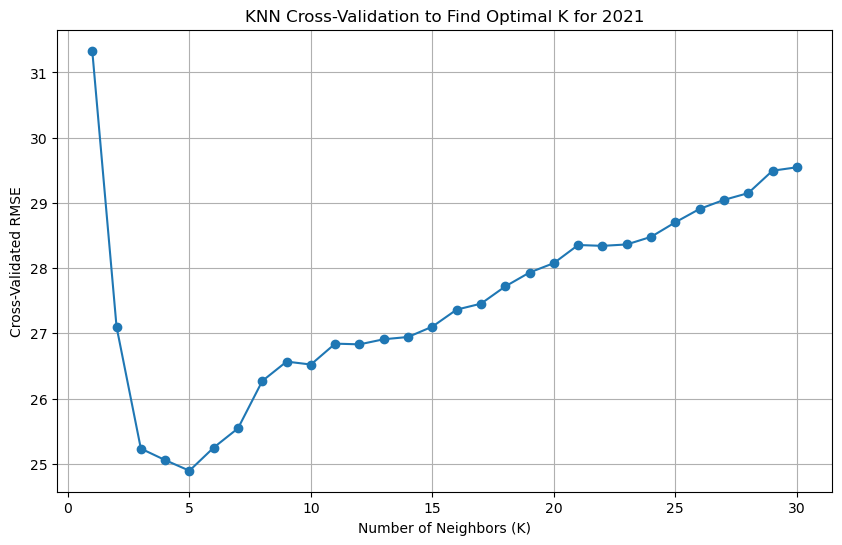

Best K value for 2021: 5 with MSE: 24.89


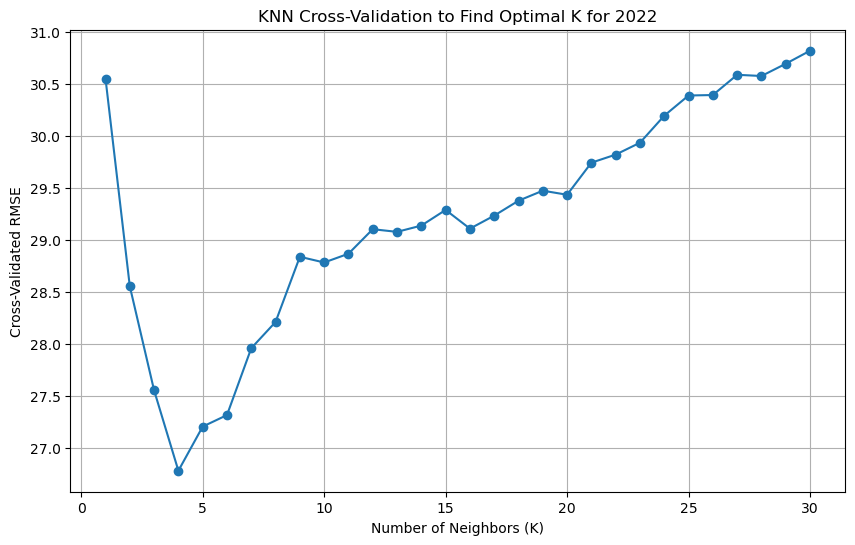

Best K value for 2022: 4 with MSE: 26.78


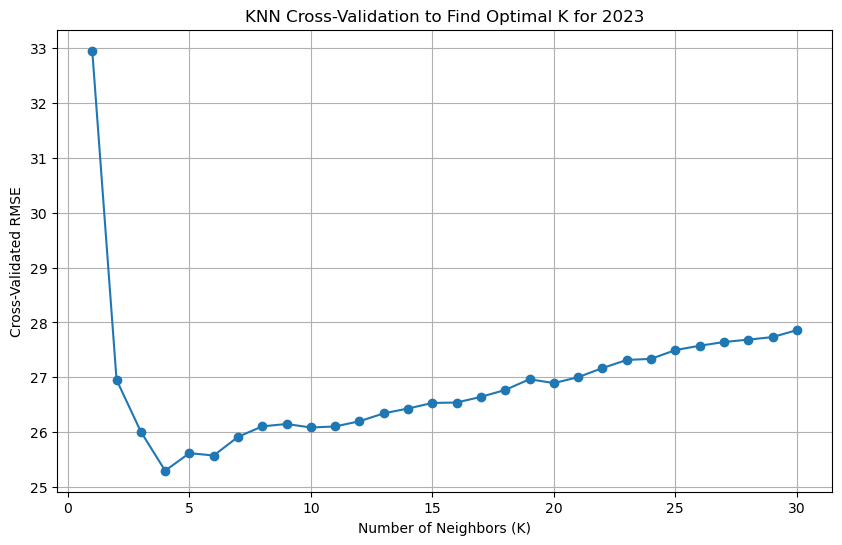

Best K value for 2023: 4 with MSE: 25.30


In [21]:
# A list that will store our KNN-MSE for each year
KNN_RMSE = []

# Loop over each year, train KNN regressor for each year
for year in [2019, 2020, 2021, 2022, 2023]:
    # Access the pre-defined train-test split for the year. Note! That what we call [X_test,y_test] is actually validation set
    X_train = train_test_splits[year]['X_train'][selected_features]
    X_test = train_test_splits[year]['X_val'][selected_features]
    y_train = train_test_splits[year]['y_train']
    y_test = train_test_splits[year]['y_val']
    
    k_values = range(1, 31)
    mean_scores = []
    # Pick k with best cross-validation error
    for k in k_values:
        knn_pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('knn', KNeighborsRegressor(n_neighbors=k))
        ])
        
        # Negative MSE (we'll take the negative again to get positive values)
        scores = cross_val_score(knn_pipeline, X_train, y_train, cv=10, scoring='neg_root_mean_squared_error')
        mean_scores.append(-scores.mean())
    
    # Plot the results for each year
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, mean_scores, marker='o')
    plt.xlabel("Number of Neighbors (K)")
    plt.ylabel("Cross-Validated RMSE")
    plt.title(f"KNN Cross-Validation to Find Optimal K for {year}")
    plt.grid(True)
    plt.show()
    
    # Best K for current year
    best_k = k_values[np.argmin(mean_scores)]
    best_mse = min(mean_scores)

    # Store the MSE for this year
    KNN_RMSE.append(best_mse)
    
    print(f"Best K value for {year}: {best_k} with MSE: {best_mse:.2f}")


#### KNN does much better than the naive model, unsurprisingly

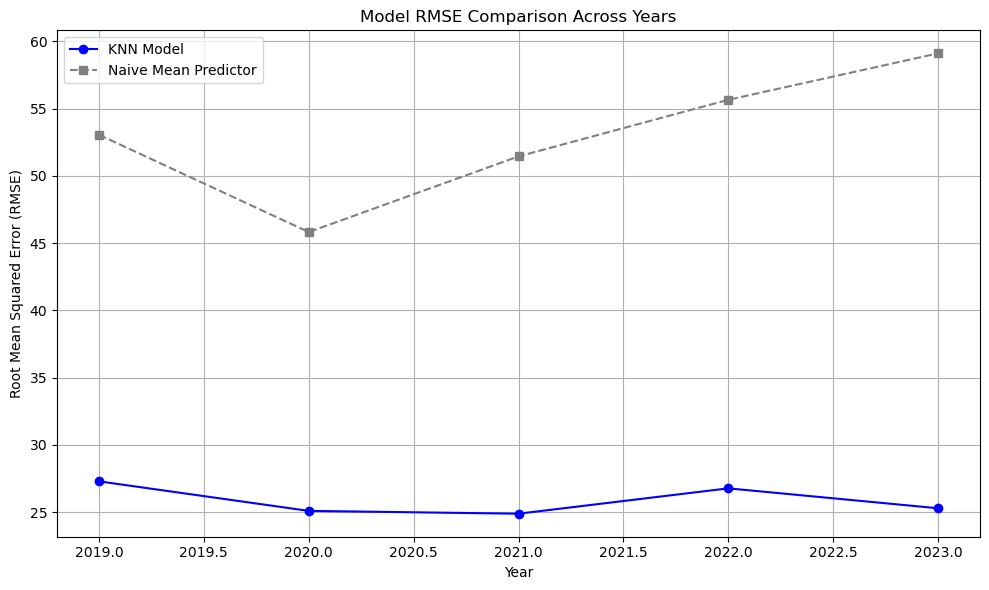

In [22]:
plt.figure(figsize=(10, 6))

# Plot KNN MSE
plt.plot([2019, 2020, 2021, 2022, 2023], KNN_RMSE, 
         marker='o', linestyle='-', color='b', label='KNN Model')

# Plot Naive MSE
plt.plot([2019, 2020, 2021, 2022, 2023], naive_RMSE, 
         marker='s', linestyle='--', color='gray', label='Naive Mean Predictor')


# Labels and title
plt.xlabel("Year")
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.title("Model RMSE Comparison Across Years")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



#### Next, we train a vanilla linear regression model for each year. We incorporate just selected features, which were chosen for having the highest linear correlation with SAT Math Average Scores.

In [23]:


# Initialize an empty list to store MSEs for Linear Regression
linreg_RMSE = []

# Loop over each dataframe (df19 to df23), train Linear Regression model for each year
for year in [2019, 2020, 2021, 2022, 2023]:
    # Access the pre-defined train-test split for the year. Note! That what we call [X_test,y_test] is actually validation set
    X_train = train_test_splits[year]['X_train'][selected_features]
    X_test = train_test_splits[year]['X_val'][selected_features]
    y_train = train_test_splits[year]['y_train']
    y_test = train_test_splits[year]['y_val']
    
    # Define pipeline with StandardScaler and LinearRegression
    linreg_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('linreg', LinearRegression())
    ])
    
    # Fit the model
    linreg_pipeline.fit(X_train, y_train)
    
    # Predict
    y_pred = linreg_pipeline.predict(X_test)
    
    # RMSE
    rmse = root_mean_squared_error(y_test, y_pred)
    linreg_RMSE.append(rmse)
    
    # Extract coefficients from trained model
    print(f"Linear Regression Coefficients for {year}:")
    print(f"Linear Regression RMSE for {year}: {rmse:.2f}\n")

Linear Regression Coefficients for 2019:
Linear Regression RMSE for 2019: 31.82

Linear Regression Coefficients for 2020:
Linear Regression RMSE for 2020: 21.13

Linear Regression Coefficients for 2021:
Linear Regression RMSE for 2021: 24.66

Linear Regression Coefficients for 2022:
Linear Regression RMSE for 2022: 24.81

Linear Regression Coefficients for 2023:
Linear Regression RMSE for 2023: 31.42



#### Vanilla linear regression does comparably well to KNN.

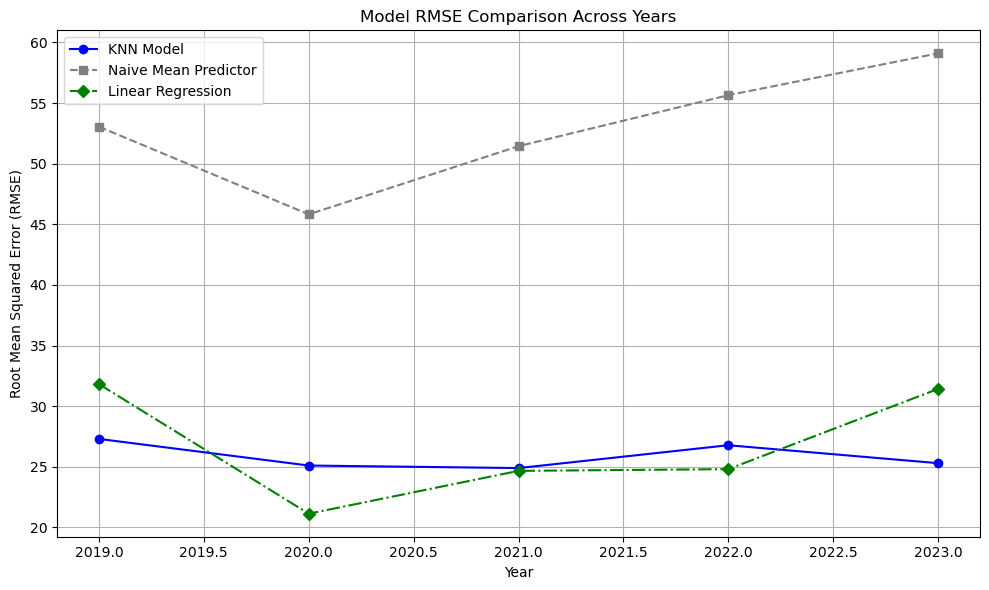

In [24]:
plt.figure(figsize=(10, 6))

# Plot KNN MSE
plt.plot([2019, 2020, 2021, 2022, 2023], KNN_RMSE, 
         marker='o', linestyle='-', color='b', label='KNN Model')

# Plot Naive MSE
plt.plot([2019, 2020, 2021, 2022, 2023], naive_RMSE, 
         marker='s', linestyle='--', color='gray', label='Naive Mean Predictor')

# Plot Linear Regression MSE
plt.plot([2019, 2020, 2021, 2022, 2023], linreg_RMSE, 
         marker='D', linestyle='-.', color='green', label='Linear Regression')



# Labels and title
plt.xlabel("Year")
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.title("Model RMSE Comparison Across Years")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



#### Now, for comparison, we use Lasso Regression using the entire set of numerical features, rather than just the pre-selected feautres. (Previously, we took the 15 most strongly correlated features as our selected features.) We compare this to Lasso's automatic feature selection.

In [25]:
# Grab all numerical features from one DataFrame
numerical_features = df19.select_dtypes(include=[np.number]).columns.drop(['SAT Math Average',"SAT Math Total Students Level 4 %","SAT Math Total Students Level 3 %", "SAT Math Total Students Level 2 %", "SAT Reading Average","SAT Math Total Students Level 1 %"])


lasso_rmse = []

for year in [2019, 2020, 2021, 2022, 2023]:
    # Extract raw splits
    X_train_raw = train_test_splits[year]['X_train'][numerical_features]
    y_train_raw = train_test_splits[year]['y_train']
    X_val_raw = train_test_splits[year]['X_val'][numerical_features]
    y_val_raw = train_test_splits[year]['y_val']

    # Combine and drop NaNs for training set
    train_df = X_train_raw.copy()
    train_df['target'] = y_train_raw
    train_df = train_df.dropna()
    X_train = train_df[numerical_features]
    y_train = train_df['target']

    # Combine and drop NaNs for validation set
    val_df = X_val_raw.copy()
    val_df['target'] = y_val_raw
    val_df = val_df.dropna()
    X_val = val_df[numerical_features]
    y_val = val_df['target']

    # Fit LassoCV
    lasso_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('lasso', LassoCV(cv=50, random_state=11))
    ])
    
    lasso_pipeline.fit(X_train, y_train)
    y_pred = lasso_pipeline.predict(X_val)
    rmse = root_mean_squared_error(y_val, y_pred)
    lasso_rmse.append(rmse)

    # Print some info
    lasso_model = lasso_pipeline.named_steps['lasso']
    coef_series = pd.Series(lasso_model.coef_, index=numerical_features)
    print(f"\nYear {year} | Lasso RMSE: {rmse:.2f}")
    print("Selected Features (non-zero coefficients):")
    print(coef_series[coef_series != 0].sort_values(key=abs, ascending=False))

    # Clean up intermediate variables
    del X_train_raw, y_train_raw, X_val_raw, y_val_raw
    del train_df, val_df, X_train, y_train, X_val, y_val
    del y_pred, coef_series






Year 2019 | Lasso RMSE: 27.96
Selected Features (non-zero coefficients):
% Student Enrollment - White                                        23.395999
% Student Enrollment - IEP                                         -20.420419
% Student Enrollment - Low Income                                  -18.045106
Chronic Absenteeism                                                -17.546702
% Student Enrollment - Hispanic or Latino                           16.015399
% Student Enrollment - Children with Disabilities                   13.281148
% Student Enrollment - EL                                          -10.265616
Avg Class Size - High School                                         7.746171
% Student Enrollment - Asian                                         7.639645
% Students with an IEP - White                                      -6.624783
Student Attendance Rate                                             -6.293225
High School Dropout Rate - Total                                    

/home/mark/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 101.50223777929205, tolerance: 96.67238177622379
  model = cd_fast.enet_coordinate_descent_gram(
/home/mark/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 103.59086261910852, tolerance: 97.34315886713287
  model = cd_fast.enet_coordinate_descent_gram(



Year 2021 | Lasso RMSE: 21.41
Selected Features (non-zero coefficients):
% Student Enrollment - Low Income                                  -19.385611
% Student Enrollment - IEP                                         -17.277274
Chronic Absenteeism                                                -14.856781
% Student Enrollment - Asian                                        11.958009
% Student Enrollment - Children with Disabilities                   11.910971
% Student Enrollment - Native Hawaiian or Other Pacific Islander     9.237518
% Student Enrollment - White                                         7.487262
Avg Class Size - High School                                         5.334946
% Student Enrollment - EL                                           -5.204841
% Student Enrollment - Black or African American                    -3.998619
Avg Number of Days of Physical Education per Week Per Student       -3.859682
Admin Avg Salary                                                    

#### Lasso does slightly better on average than vanilla linear regression or KNN

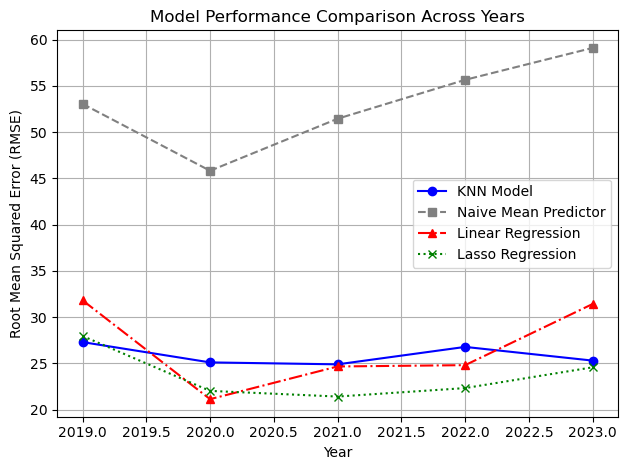

In [26]:


# Plot KNN MSE
plt.plot([2019, 2020, 2021, 2022, 2023], KNN_RMSE, 
         marker='o', linestyle='-', color='b', label='KNN Model')

# Plot Naive MSE
plt.plot([2019, 2020, 2021, 2022, 2023], naive_RMSE, 
         marker='s', linestyle='--', color='gray', label='Naive Mean Predictor')

# Plot Linear Regression MSE
plt.plot([2019, 2020, 2021, 2022, 2023], linreg_RMSE, 
         marker='^', linestyle='-.', color='r', label='Linear Regression')

# Plot Lasso MSE
plt.plot([2019, 2020, 2021, 2022, 2023], lasso_rmse, 
         marker='x', linestyle=':', color='g', label='Lasso Regression')

# Add labels and title
plt.xlabel("Year")
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.title("Model Performance Comparison Across Years")

# Show grid and legend
plt.grid(True)
plt.legend()

# Tight layout and show plot
plt.tight_layout()
plt.show()



#### Finally, we compare Lasso with Ridge regression. We use RidgeCV to automatically pick the regularization parameter.

In [27]:

ridge_rmse = []

for year in [2019, 2020, 2021, 2022, 2023]:
    # Extract raw splits
    X_train_raw = train_test_splits[year]['X_train'][numerical_features]
    y_train_raw = train_test_splits[year]['y_train']
    X_val_raw = train_test_splits[year]['X_val'][numerical_features]
    y_val_raw = train_test_splits[year]['y_val']

    # Combine and drop NaNs for training set
    train_df = X_train_raw.copy()
    train_df['target'] = y_train_raw
    train_df = train_df.dropna()
    X_train = train_df[numerical_features]
    y_train = train_df['target']

    # Combine and drop NaNs for validation set
    val_df = X_val_raw.copy()
    val_df['target'] = y_val_raw
    val_df = val_df.dropna()
    X_val = val_df[numerical_features]
    y_val = val_df['target']

    alphas = np.logspace(-3, 3, 50)

    ridge_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('ridge', RidgeCV(alphas=alphas, store_cv_results=True))
    ])



    ridge_pipeline.fit(X_train, y_train)
    
    y_pred = ridge_pipeline.predict(X_val)
    rmse = root_mean_squared_error(y_val, y_pred)


    best_alpha = ridge_pipeline.named_steps['ridge'].alpha_
    print(f"Best alpha: {best_alpha}")


    ridge_rmse.append(rmse)

    ridge_model = ridge_pipeline.named_steps['ridge']
    coef_series = pd.Series(ridge_model.coef_, index=numerical_features)
    print(f"\nYear {year} | Ridge RMSE: {rmse:.2f}")
    print("Top Features (by magnitude):")
    print(coef_series.sort_values(key=abs, ascending=False))

Best alpha: 2.023589647725158

Year 2019 | Ridge RMSE: 27.95
Top Features (by magnitude):
% Student Enrollment - White                                        21.462323
% Student Enrollment - IEP                                         -20.336430
% Student Enrollment - Low Income                                  -17.842855
Chronic Absenteeism                                                -17.414481
% Student Enrollment - Hispanic or Latino                           14.099627
% Student Enrollment - Children with Disabilities                   13.099538
% Student Enrollment - EL                                          -10.123931
Avg Class Size - High School                                         7.855936
% Student Enrollment - Asian                                         7.204120
% Students with an IEP - White                                      -7.077381
Student Attendance Rate                                             -6.944801
High School Dropout Rate - Total                    

#### Ridge and Lasso perform nearly identically.

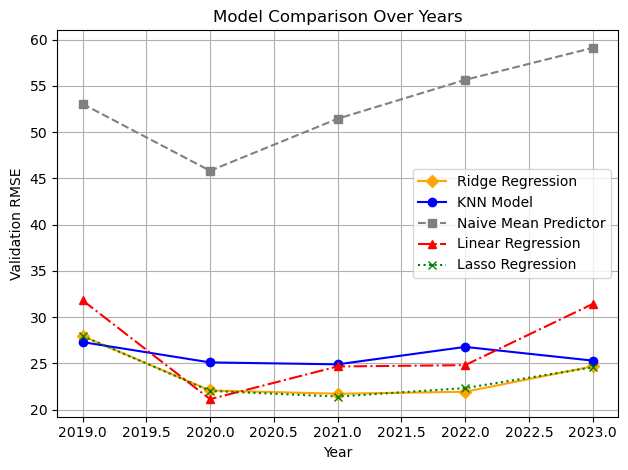

In [28]:
# Plot Ridge RMSE
plt.plot([2019, 2020, 2021, 2022, 2023], ridge_rmse, 
         marker='D', linestyle='-', color='orange', label='Ridge Regression')

# Plot the rest
plt.plot([2019, 2020, 2021, 2022, 2023], KNN_RMSE, 
         marker='o', linestyle='-', color='b', label='KNN Model')

plt.plot([2019, 2020, 2021, 2022, 2023], naive_RMSE, 
         marker='s', linestyle='--', color='gray', label='Naive Mean Predictor')

plt.plot([2019, 2020, 2021, 2022, 2023], linreg_RMSE, 
         marker='^', linestyle='-.', color='r', label='Linear Regression')

plt.plot([2019, 2020, 2021, 2022, 2023], lasso_rmse, 
         marker='x', linestyle=':', color='g', label='Lasso Regression')

# Finalize plot
plt.xlabel("Year")
plt.ylabel("Validation RMSE")
plt.title("Model Comparison Over Years")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


[0]	validation_0-rmse:50.55262
[1]	validation_0-rmse:48.03313
[2]	validation_0-rmse:46.15851
[3]	validation_0-rmse:44.23648
[4]	validation_0-rmse:42.66866
[5]	validation_0-rmse:41.20432
[6]	validation_0-rmse:39.75996
[7]	validation_0-rmse:38.63902
[8]	validation_0-rmse:37.53206
[9]	validation_0-rmse:36.69144
[10]	validation_0-rmse:35.87080
[11]	validation_0-rmse:35.12096
[12]	validation_0-rmse:34.57728
[13]	validation_0-rmse:33.87576
[14]	validation_0-rmse:33.19608
[15]	validation_0-rmse:32.75818
[16]	validation_0-rmse:32.45689
[17]	validation_0-rmse:32.09883
[18]	validation_0-rmse:31.73521
[19]	validation_0-rmse:31.33460
[20]	validation_0-rmse:30.96966
[21]	validation_0-rmse:30.51663
[22]	validation_0-rmse:30.44520
[23]	validation_0-rmse:30.14842
[24]	validation_0-rmse:30.07552
[25]	validation_0-rmse:29.91030
[26]	validation_0-rmse:29.87282
[27]	validation_0-rmse:29.55686
[28]	validation_0-rmse:29.38404
[29]	validation_0-rmse:29.35457
[30]	validation_0-rmse:29.35607
[31]	validation_0-

[27.198646065884923,
 20.9452972632389,
 21.7341773872611,
 18.304692167484557,
 23.38264074752189]

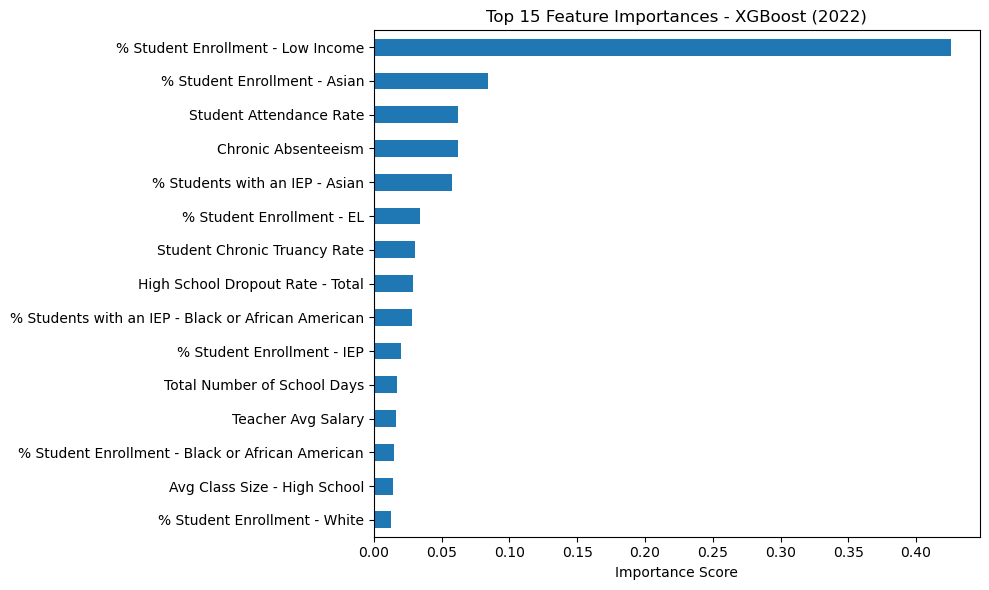

In [62]:
import xgboost as xgb
from xgboost.callback import EarlyStopping


xgb_rmse = []
feature_importances_by_year = {}

for year in [2019, 2020, 2021, 2022, 2023]:
    # Extract raw splits
    X_train_raw = train_test_splits[year]['X_train'][numerical_features]
    y_train_raw = train_test_splits[year]['y_train']
    X_val_raw = train_test_splits[year]['X_val'][numerical_features]
    y_val_raw = train_test_splits[year]['y_val']

    # Combine and drop NaNs for training set
    train_df = X_train_raw.copy()
    train_df['target'] = y_train_raw
    train_df = train_df.dropna()
    X_train = train_df[numerical_features]
    y_train = train_df['target']

    # Combine and drop NaNs for validation set
    val_df = X_val_raw.copy()
    val_df['target'] = y_val_raw
    val_df = val_df.dropna()
    X_val = val_df[numerical_features]
    y_val = val_df['target']

    # Train XGBoost model
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        eval_metric='rmse',
        learning_rate=0.1,
        max_depth=3,
        n_estimators=100,
        random_state=11,
        early_stopping_rounds=10  # Early stopping parameter
    )

    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)]
    )

    y_pred = model.predict(X_val)
    rmse = root_mean_squared_error(y_val, y_pred)
    xgb_rmse.append(rmse)

    # Save feature importances
    importances = model.feature_importances_
    feature_importances_by_year[year] = pd.Series(importances, index=numerical_features).sort_values(ascending=False)

# Plot feature importance for 2023
fig, ax = plt.subplots(figsize=(10, 6))
feature_importances_by_year[2022].head(15).plot(kind='barh', ax=ax)
ax.set_title('Top 15 Feature Importances - XGBoost (2022)')
ax.set_xlabel('Importance Score')
ax.invert_yaxis()
plt.tight_layout()

xgb_rmse



#### We run a randomized parameter search to find good parameters for the XGBoost Models:

[0]	validation_0-rmse:53.69726
[1]	validation_0-rmse:53.66673
[2]	validation_0-rmse:53.63812
[3]	validation_0-rmse:53.60789
[4]	validation_0-rmse:53.57334
[5]	validation_0-rmse:53.54254
[6]	validation_0-rmse:53.50723
[7]	validation_0-rmse:53.47930
[8]	validation_0-rmse:53.44773
[9]	validation_0-rmse:53.41986
[10]	validation_0-rmse:53.38874
[11]	validation_0-rmse:53.35598
[12]	validation_0-rmse:53.32716
[13]	validation_0-rmse:53.29654
[14]	validation_0-rmse:53.27170
[15]	validation_0-rmse:53.24871
[16]	validation_0-rmse:53.21862
[17]	validation_0-rmse:53.18873
[18]	validation_0-rmse:53.15836
[19]	validation_0-rmse:53.12777
[20]	validation_0-rmse:53.09850
[21]	validation_0-rmse:53.07208
[22]	validation_0-rmse:53.04132
[23]	validation_0-rmse:53.01418
[24]	validation_0-rmse:52.97991
[25]	validation_0-rmse:52.94836
[26]	validation_0-rmse:52.91777
[27]	validation_0-rmse:52.88408
[28]	validation_0-rmse:52.85334
[29]	validation_0-rmse:52.82327
[30]	validation_0-rmse:52.78898
[31]	validation_0-

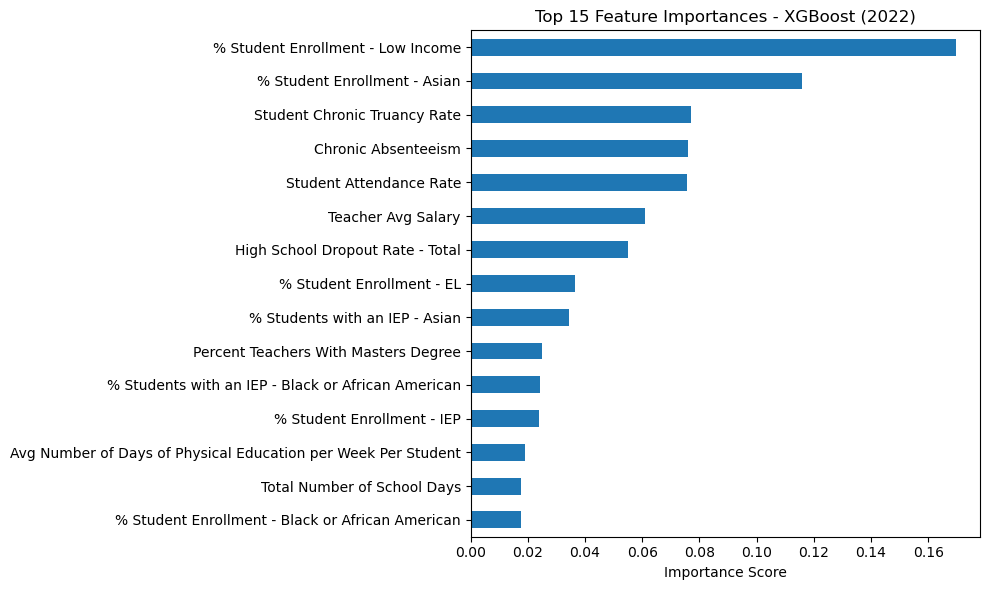

In [ ]:
runrandomsearch = False #This next block takes a long time to run. Therefore it's behind this little boolean gate, so it only runs if you really mean it.

if runrandomsearch:
    from sklearn.model_selection import RandomizedSearchCV

    xgb_rmse = []
    feature_importances_by_year = {}
    best_xgmodels_by_year = {}


    # Define the parameter grid for RandomizedSearchCV
    param_dist = {
        'learning_rate': np.logspace(-3, 0, 4),  # Example values for learning rate
        'max_depth': [3, 5, 7, 9],
        'n_estimators': [50, 100, 200],
        'subsample': [0.7, 0.8, 0.9, 1],
        'colsample_bytree': [0.7, 0.8, 0.9, 1],
        'gamma': [0, 0.1, 0.2, 0.3]
    }

    # Loop over each year
    for year in [2019, 2020, 2021, 2022, 2023]:
        # Extract raw splits
        X_train_raw = train_test_splits[year]['X_train'][numerical_features]
        y_train_raw = train_test_splits[year]['y_train']
        X_val_raw = train_test_splits[year]['X_val'][numerical_features]
        y_val_raw = train_test_splits[year]['y_val']

        # Combine and drop NaNs for training set
        train_df = X_train_raw.copy()
        train_df['target'] = y_train_raw
        train_df = train_df.dropna()
        X_train = train_df[numerical_features]
        y_train = train_df['target']

        # Combine and drop NaNs for validation set
        val_df = X_val_raw.copy()
        val_df['target'] = y_val_raw
        val_df = val_df.dropna()
        X_val = val_df[numerical_features]
        y_val = val_df['target']

        # Initialize XGBRegressor for RandomizedSearchCV
        model = xgb.XGBRegressor(
            objective='reg:squarederror',
            eval_metric='rmse',
            random_state=11,
            early_stopping_rounds=10  # Early stopping parameter
        )

        # Set up RandomizedSearchCV
        random_search = RandomizedSearchCV(
            model,
            param_distributions=param_dist,
            n_iter=10,  # Number of iterations (you can adjust this based on how many combinations you want to try)
            scoring='neg_mean_squared_error',  # Use negative MSE for regression tasks
            cv=3,  # 3-fold cross-validation
            random_state=11
        )

        # Fit RandomizedSearchCV
        random_search.fit(X_train, y_train, eval_set=[(X_val, y_val)])

        # Best model from random search
        best_model = random_search.best_estimator_
        best_xgmodels_by_year[year] = best_model 

        # Get RMSE on the validation set
        y_pred = best_model.predict(X_val)
        rmse = root_mean_squared_error(y_val, y_pred)
        xgb_rmse.append(rmse)

        # Save feature importances from the best model
        importances = best_model.feature_importances_
        feature_importances_by_year[year] = pd.Series(importances, index=numerical_features).sort_values(ascending=False)

    # Plot feature importance for 2023
    fig, ax = plt.subplots(figsize=(10, 6))
    feature_importances_by_year[2023].head(15).plot(kind='barh', ax=ax)
    ax.set_title('Top 15 Feature Importances - XGBoost (2022)')
    ax.set_xlabel('Importance Score')
    ax.invert_yaxis()
    plt.tight_layout()


#### In the end, XGBoost looks to be have the lowest prediction error.

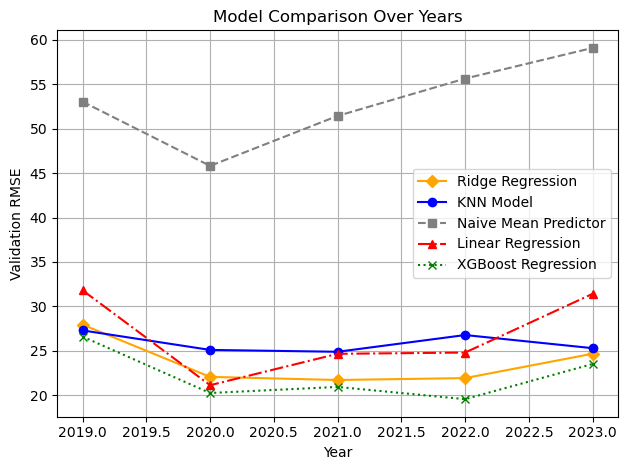

In [34]:
# Plot Ridge RMSE
plt.plot([2019, 2020, 2021, 2022, 2023], ridge_rmse, 
         marker='D', linestyle='-', color='orange', label='Ridge Regression')

# Plot the rest
plt.plot([2019, 2020, 2021, 2022, 2023], KNN_RMSE, 
         marker='o', linestyle='-', color='b', label='KNN Model')

plt.plot([2019, 2020, 2021, 2022, 2023], naive_RMSE, 
         marker='s', linestyle='--', color='gray', label='Naive Mean Predictor')

plt.plot([2019, 2020, 2021, 2022, 2023], linreg_RMSE, 
         marker='^', linestyle='-.', color='r', label='Linear Regression')

plt.plot([2019, 2020, 2021, 2022, 2023], xgb_rmse, 
         marker='x', linestyle=':', color='g', label='XGBoost Regression')

# Finalize plot
plt.xlabel("Year")
plt.ylabel("Validation RMSE")
plt.title("Model Comparison Over Years")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### Finally, since XGBoost is the winner, we use the best XGBoost Models on our *test* data. We'll take the W.

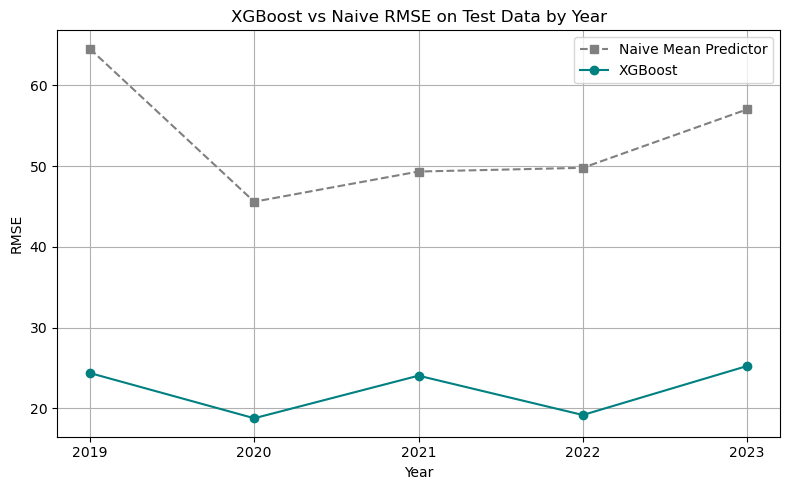

In [96]:
test_xgb_rmse_by_year = {}
test_naive_rmse_by_year = []

for year in [2019, 2020, 2021, 2022, 2023]:
    # Grab the test features and target
    X_test_raw = train_test_splits[year]['X_test'][numerical_features]
    y_test_raw = train_test_splits[year]['y_test']

    # Drop NaNs (same as we did for train/val)
    test_df = X_test_raw.copy()
    test_df['target'] = y_test_raw
    test_df = test_df.dropna()
    X_test = test_df[numerical_features]
    y_test = test_df['target']

    # Grab the model and predict
    model = best_xgmodels_by_year[year]
    y_pred = model.predict(X_test)
    
    # Calculate and store RMSE
    rmse = root_mean_squared_error(y_test, y_pred)
    test_xgb_rmse_by_year[year] = rmse


    y_pred_naive = [y_train.mean()] * len(y_test)
    test_naive_rmse_by_year.append(root_mean_squared_error(y_pred_naive,y_test))
    
    # Compute MSE
# Print the RMSE for each year
years = list(test_rmse_by_year.keys())
xgb_rmse_values = list(test_rmse_by_year.values())


# Plot it!
plt.figure(figsize=(8, 5))
plt.plot(years, test_naive_rmse_by_year, 
         marker='s', linestyle='--', color='gray', label='Naive Mean Predictor')
plt.plot(years, xgb_rmse_values, 
         marker='o', linestyle='-', color='teal', label='XGBoost')

# Add titles and labels
plt.title("XGBoost vs Naive RMSE on Test Data by Year")
plt.xlabel("Year")
plt.ylabel("RMSE")
plt.grid(True)
plt.xticks(years)
plt.legend()
plt.tight_layout()
plt.show()

# Modelling Change From 2019
#### In this section, we shift our focus to modelling *changes* in scores from 2019. We hope to uncover some details abou the effects of the COVID 19 pandemic in the process. 
The strategy will be to use all available features from the 2019 data. We will use these features and various regression models to attempt to predict how much a school's scores will change post pandemic. In this way, we hope to gain some insight into which populations were most effected by the pandemic years in terms of math performance

In [36]:
#Begin by computing change in scores for each school for each year since 2019.as_integer_ratio
# Create a dictionary for easy reference
dfs_by_year = {
    2019: df19,
    2020: df20,
    2021: df21,
    2022: df22,
    2023: df23
}

# Compute score changes from 2019
score_changes_by_year = {}

for year in [2020, 2021, 2022, 2023]:
    # Select only relevant columns from the year’s DataFrame
    right_df = dfs_by_year[year][["RCDTS", "SAT Math Average"]].copy()

    # Rename the right-hand score column so we know which year it’s from
    right_df.rename(columns={"SAT Math Average": f"SAT Math Average {year}"}, inplace=True)

    # Merge into the 2019 base
    dfs_by_year[2019] = dfs_by_year[2019].merge(right_df, on="RCDTS", how="left")

    # Compute delta
    dfs_by_year[2019][f"Score Delta {year}"] = (
        dfs_by_year[2019][f"SAT Math Average {year}"] - dfs_by_year[2019]["SAT Math Average"]
    )



#### Oh those scores definitely dropped!
Take a look at the violin plot below.

/tmp/ipykernel_140483/1382131548.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=delta_df, x="Year", y="Score Delta", inner="box", palette="Set2")


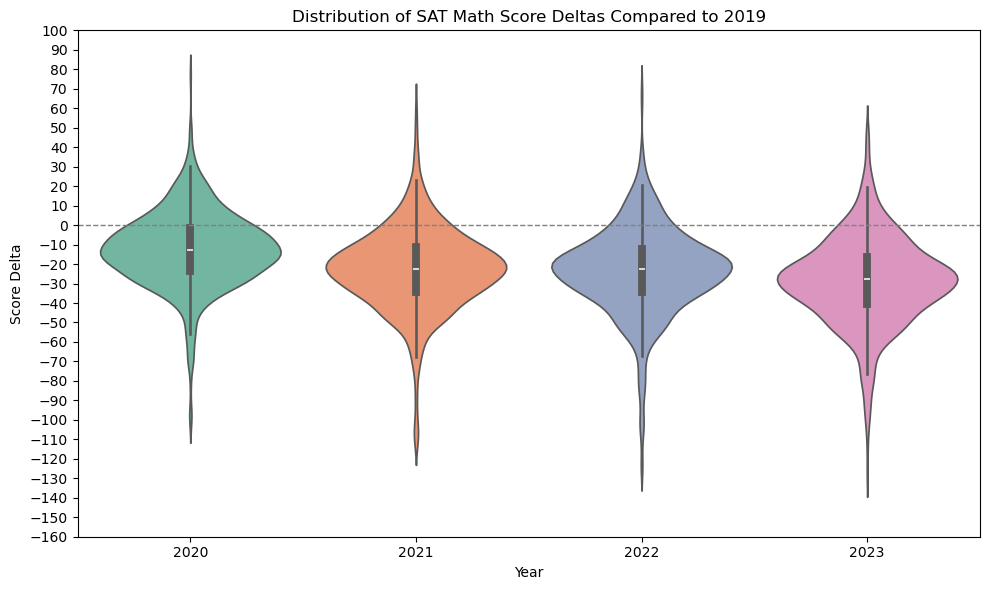

In [80]:


# Gather all the delta columns into long-form for plotting
delta_cols = [f"Score Delta {year}" for year in [2020, 2021, 2022, 2023]]

# Melt the DataFrame to long format
delta_df = dfs_by_year[2019][["RCDTS"] + delta_cols].melt(
    id_vars="RCDTS",
    value_vars=delta_cols,
    var_name="Year",
    value_name="Score Delta"
)

# Clean up year labels
delta_df["Year"] = delta_df["Year"].str.extract(r"(\d{4})")

# Create the violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(data=delta_df, x="Year", y="Score Delta", inner="box", palette="Set2")

# Subdivide y-axis in increments of 10
y_min, y_max = plt.ylim()
plt.yticks(np.arange(np.floor(y_min / 10) * 10, np.ceil(y_max / 10) * 10 + 1, 10))

plt.title("Distribution of SAT Math Score Deltas Compared to 2019")
plt.ylabel("Score Delta")
plt.xlabel("Year")
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()

#### We'll train the same battery of regressors we used in the previous sections: A naive regressor (just predicts 2019 mean score for each school each year), a linear regressor, including with Lasso, a KNN model, and finally, an XG Boost model.

In [83]:
# Prepare a dictionary to store train, validation, and test splits for each year
splits_by_year = {}

# Loop over each year 2020-2023
for year in [2020, 2021, 2022, 2023]:
    # Extract features from dfs_by_year[2019] (numeric columns)
    X = dfs_by_year[2019][numerical_features]
    
    # Extract target (f"Score Delta {year}")
    y = dfs_by_year[2019][f"Score Delta {year}"]
    
    # Drop rows where either the target (y) or the features (X) are NaN
    valid_rows = X.dropna().index.intersection(y.dropna().index)  # Keep only rows where both X and y are valid
    X_valid = X.loc[valid_rows]
    y_valid = y.loc[valid_rows]
    
    # Perform a train-test split (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(X_valid, y_valid, test_size=0.2, random_state=11)
    
    # Now split the training data into train and validation (80% train, 20% validation)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=11)
    
    # Store the splits in the dictionary
    splits_by_year[year] = {
        'X_train': X_train,
        'X_val': X_val,
        'X_test': X_test,
        'y_train': y_train,
        'y_val': y_val,
        'y_test': y_test
    }
    
    # Clean up memory
    del X, X_valid, y_valid, valid_rows
    del X_train, X_val, y_train, y_val


In [113]:
# List to store the naive model MSE for each year
delta_naive_RMSE = []

for year in [2020, 2021, 2022, 2023]:
    # Access the pre-defined train-validation split
    X_train = splits_by_year[year]['X_train']
    X_test = splits_by_year[year]['X_val']
    y_train = splits_by_year[year]['y_train']
    y_test = splits_by_year[year]['y_val']
    
    # Naive prediction: mean of the training targets
    y_pred_naive = [0] * len(y_test)
    
    # Compute RMSE
    delta_rmse_naive = root_mean_squared_error(y_test, y_pred_naive)
    delta_naive_RMSE.append(delta_rmse_naive)
    
    print(f"Naive Model RMSE for {year}: {delta_rmse_naive:.2f}")


Naive Model RMSE for 2020: 24.59
Naive Model RMSE for 2021: 32.29
Naive Model RMSE for 2022: 33.06
Naive Model RMSE for 2023: 38.40


#### Here we train the KNN regressor. 

In [90]:
# A list that will store our KNN-MSE for each year
delta_KNN_RMSE = []

# Loop over each year, train KNN regressor for each year
for year in [ 2020, 2021, 2022, 2023]:
    # Access the pre-defined train-test split for the year. Note! That what we call [X_test,y_test] is actually validation set
    X_train = splits_by_year[year]['X_train'][selected_features]
    X_test = splits_by_year[year]['X_val'][selected_features]
    y_train = splits_by_year[year]['y_train']
    y_test = splits_by_year[year]['y_val']
    
    k_values = range(1, 31)
    mean_scores = []
    # Pick k with best cross-validation error
    for k in k_values:
        knn_pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('knn', KNeighborsRegressor(n_neighbors=k))
        ])
        
        # Negative MSE (we'll take the negative again to get positive values)
        scores = cross_val_score(knn_pipeline, X_train, y_train, cv=10, scoring='neg_root_mean_squared_error')
        mean_scores.append(-scores.mean())
    
    # # Plot the results for each year
    # plt.figure(figsize=(10, 6))
    # plt.plot(k_values, mean_scores, marker='o')
    # plt.xlabel("Number of Neighbors (K)")
    # plt.ylabel("Cross-Validated RMSE")
    # plt.title(f"KNN Cross-Validation to Find Optimal K for {year}")
    # plt.grid(True)
    # plt.show()
    
    # Best K for current year
    best_k = k_values[np.argmin(mean_scores)]
    best_mse = min(mean_scores)

    # Store the MSE for this year
    delta_KNN_RMSE.append(best_mse)
    
    print(f"Best K value for {year}: {best_k} with MSE: {best_mse:.2f}")


Best K value for 2020: 22 with MSE: 18.47
Best K value for 2021: 29 with MSE: 19.98
Best K value for 2022: 8 with MSE: 21.38
Best K value for 2023: 13 with MSE: 22.28


#### Next we train vanilla linear regression.

In [47]:


# Initialize an empty list to store MSEs for Linear Regression
delta_linreg_RMSE = []

# Loop over each dataframe (df19 to df23), train Linear Regression model for each year
for year in [2020, 2021, 2022, 2023]:
    # Access the pre-defined train-test split for the year. Note! That what we call [X_test,y_test] is actually validation set
    X_train = splits_by_year[year]['X_train'][selected_features]
    X_test = splits_by_year[year]['X_val'][selected_features]
    y_train = splits_by_year[year]['y_train']
    y_test = splits_by_year[year]['y_val']
    
    # Define pipeline with StandardScaler and LinearRegression
    linreg_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('linreg', LinearRegression())
    ])
    
    # Fit the model
    linreg_pipeline.fit(X_train, y_train)
    
    # Predict
    y_pred = linreg_pipeline.predict(X_test)
    
    # RMSE
    rmse = root_mean_squared_error(y_test, y_pred)
    delta_linreg_RMSE.append(rmse)
    
    # Extract coefficients from trained model
    print(f"Linear Regression Coefficients for {year}:")
    print(f"Linear Regression RMSE for {year}: {rmse:.2f}\n")

Linear Regression Coefficients for 2020:
Linear Regression RMSE for 2020: 19.77

Linear Regression Coefficients for 2021:
Linear Regression RMSE for 2021: 20.90

Linear Regression Coefficients for 2022:
Linear Regression RMSE for 2022: 19.97

Linear Regression Coefficients for 2023:
Linear Regression RMSE for 2023: 22.46



#### Linear Regression and KNN are both able to do much better than the naive model. 

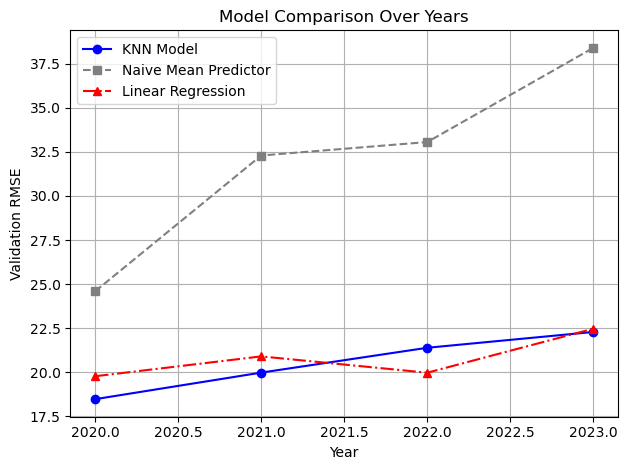

In [114]:
# # Plot Ridge RMSE
# plt.plot([2019, 2020, 2021, 2022, 2023], ridge_rmse, 
#          marker='D', linestyle='-', color='orange', label='Ridge Regression')

# Plot the rest
plt.plot([ 2020, 2021, 2022, 2023], delta_KNN_RMSE, 
         marker='o', linestyle='-', color='b', label='KNN Model')

plt.plot([2020, 2021, 2022, 2023], delta_naive_RMSE, 
         marker='s', linestyle='--', color='gray', label='Naive Mean Predictor')

plt.plot([2020, 2021, 2022, 2023], delta_linreg_RMSE, 
         marker='^', linestyle='-.', color='r', label='Linear Regression')

# plt.plot([2019, 2020, 2021, 2022, 2023], xgb_rmse, 
#          marker='x', linestyle=':', color='g', label='XGBoost Regression')

# Finalize plot
plt.xlabel("Year")
plt.ylabel("Validation RMSE")
plt.title("Model Comparison Over Years")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### Introduce Lasso regularization

In [55]:
# Grab all numerical features from one DataFrame
delta_lasso_rmse = []

for year in [2020, 2021, 2022, 2023]:
    # Extract raw splits
    X_train_raw = splits_by_year[year]['X_train'][numerical_features]
    y_train_raw = splits_by_year[year]['y_train']
    X_val_raw = splits_by_year[year]['X_val'][numerical_features]
    y_val_raw = splits_by_year[year]['y_val']

    # Combine and drop NaNs for training set
    train_df = X_train_raw.copy()
    train_df['target'] = y_train_raw
    train_df = train_df.dropna()
    X_train = train_df[numerical_features]
    y_train = train_df['target']

    # Combine and drop NaNs for validation set
    val_df = X_val_raw.copy()
    val_df['target'] = y_val_raw
    val_df = val_df.dropna()
    X_val = val_df[numerical_features]
    y_val = val_df['target']

    # Fit LassoCV
    lasso_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('lasso', LassoCV(cv=50, random_state=11))
    ])
    
    lasso_pipeline.fit(X_train, y_train)
    y_pred = lasso_pipeline.predict(X_val)
    rmse = root_mean_squared_error(y_val, y_pred)
    delta_lasso_rmse.append(rmse)

    # Print some info
    lasso_model = lasso_pipeline.named_steps['lasso']
    coef_series = pd.Series(lasso_model.coef_, index=numerical_features)
    print(f"\nYear {year} | Lasso RMSE: {rmse:.2f}")
    print("Selected Features (non-zero coefficients):")
    print(coef_series[coef_series != 0].sort_values(key=abs, ascending=False))

    # Clean up intermediate variables
    del X_train_raw, y_train_raw, X_val_raw, y_val_raw
    del train_df, val_df, X_train, y_train, X_val, y_val
    del y_pred, coef_series





/home/mark/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.040941008293885, tolerance: 16.983419601415093
  model = cd_fast.enet_coordinate_descent_gram(
/home/mark/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.763269870105432, tolerance: 16.983419601415093
  model = cd_fast.enet_coordinate_descent_gram(
/home/mark/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.55965300591197, tolerance: 16.983419601415093
  model = cd_fast.enet_coordinate_descent_gram(
/home/mark/anaconda3/lib/python3.12/site-packages/sklearn/linear_mod


Year 2020 | Lasso RMSE: 19.68
Selected Features (non-zero coefficients):
% Student Enrollment - Hispanic or Latino                          -5.167508
$ Site-level Per-Pupil Expenditures - Subtotal                     -4.168213
Chronic Absenteeism                                                 3.902942
Avg Class Size - High School                                       -3.182204
Admin Avg Salary                                                    2.887220
Avg Number of Days of Physical Education per Week Per Student       2.877369
High School Dropout Rate - Total                                    2.367070
% Student Enrollment - EL                                           2.256825
Total Number of School Days                                        -2.209198
% Students with an IEP - Asian                                     -1.902417
Teacher Retention Rate                                              1.699654
# Student Enrollment                                                1.449760
$ 

/home/mark/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.869432333041914, tolerance: 18.20473287703016
  model = cd_fast.enet_coordinate_descent_gram(
/home/mark/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22.290626447240356, tolerance: 18.20473287703016
  model = cd_fast.enet_coordinate_descent_gram(
/home/mark/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38.00641865772195, tolerance: 18.20473287703016
  model = cd_fast.enet_coordinate_descent_gram(
/home/mark/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/


Year 2021 | Lasso RMSE: 20.73
Selected Features (non-zero coefficients):
Chronic Absenteeism                                              4.813601
Avg Class Size - High School                                    -2.179408
Avg Number of Days of Physical Education per Week Per Student    1.918459
High School Dropout Rate - Total                                 1.493011
% Student Enrollment - Children with Disabilities               -1.257317
Teacher Attendance Rate                                          1.017834
% Student Enrollment - Asian                                     0.732567
% Student Enrollment - American Indian or Alaska Native         -0.564869
% Student Enrollment - Hispanic or Latino                       -0.549514
Student Attendance Rate                                         -0.232582
$ Site-level Per-Pupil Expenditures - Subtotal                  -0.225316
% Student Enrollment - White                                     0.201029
Teacher Retention Rate                

/home/mark/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.830470712622628, tolerance: 21.594056578088583
  model = cd_fast.enet_coordinate_descent_gram(
/home/mark/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29.28570560074877, tolerance: 21.594056578088583
  model = cd_fast.enet_coordinate_descent_gram(
/home/mark/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29.31070258904947, tolerance: 21.594056578088583
  model = cd_fast.enet_coordinate_descent_gram(
/home/mark/anaconda3/lib/python3.12/site-packages/sklearn/linear_mode


Year 2022 | Lasso RMSE: 19.30
Selected Features (non-zero coefficients):
Chronic Absenteeism                                              4.361787
Avg Class Size - High School                                    -3.050255
% Student Enrollment - Hispanic or Latino                       -2.608978
Teacher Retention Rate                                           2.552123
Avg Number of Days of Physical Education per Week Per Student    2.070593
High School Dropout Rate - Total                                 1.214807
% Student Enrollment - Two or More Races                         0.666376
Total Number of School Days                                     -0.486929
% Student Enrollment - Asian                                     0.167839
dtype: float64


/home/mark/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41.82169418796548, tolerance: 22.125166912529547
  model = cd_fast.enet_coordinate_descent_gram(
/home/mark/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57.30801479698857, tolerance: 22.125166912529547
  model = cd_fast.enet_coordinate_descent_gram(
/home/mark/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 59.53931116175954, tolerance: 22.125166912529547
  model = cd_fast.enet_coordinate_descent_gram(
/home/mark/anaconda3/lib/python3.12/site-packages/sklearn/linear_model


Year 2023 | Lasso RMSE: 21.64
Selected Features (non-zero coefficients):
Avg Class Size - High School                                       -3.016319
Chronic Absenteeism                                                 2.862722
% Student Enrollment - Hispanic or Latino                          -2.638646
% Student Enrollment - Children with Disabilities                  -2.634353
Admin Avg Salary                                                    2.192577
% Student Enrollment - Native Hawaiian or Other Pacific Islander    2.128169
Teacher Retention Rate                                              2.013681
% Students with an IEP - White                                      1.594716
$ Total Per-Pupil Expenditures - Subtotal                          -1.544775
Avg Number of Days of Physical Education per Week Per Student       1.266177
% Student Enrollment - Two or More Races                            1.096040
% Student Enrollment - IEP                                          0.985417
Hi

/home/mark/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44.703011216799496, tolerance: 21.996191584905656
  model = cd_fast.enet_coordinate_descent_gram(
/home/mark/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36.525167009356664, tolerance: 21.733146377358487
  model = cd_fast.enet_coordinate_descent_gram(
/home/mark/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39.914379535097396, tolerance: 21.733146377358487
  model = cd_fast.enet_coordinate_descent_gram(
/home/mark/anaconda3/lib/python3.12/site-packages/sklearn/linear_mo

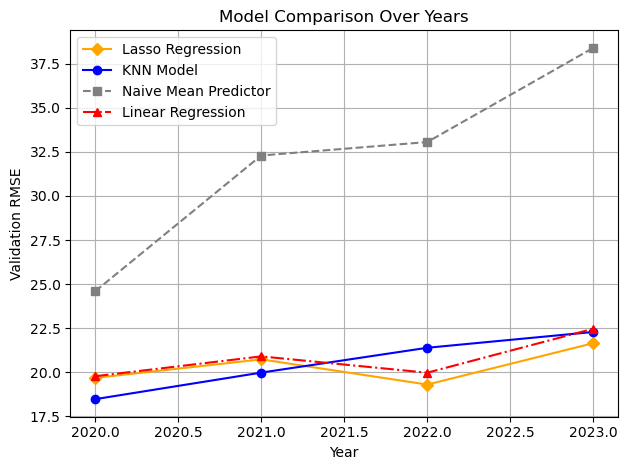

In [115]:
# # Plot Ridge RMSE
plt.plot([2020, 2021, 2022, 2023], delta_lasso_rmse, 
         marker='D', linestyle='-', color='orange', label='Lasso Regression')

# Plot the rest
plt.plot([ 2020, 2021, 2022, 2023], delta_KNN_RMSE, 
         marker='o', linestyle='-', color='b', label='KNN Model')

plt.plot([2020, 2021, 2022, 2023], delta_naive_RMSE, 
         marker='s', linestyle='--', color='gray', label='Naive Mean Predictor')

plt.plot([2020, 2021, 2022, 2023], delta_linreg_RMSE, 
         marker='^', linestyle='-.', color='r', label='Linear Regression')

# plt.plot([2019, 2020, 2021, 2022, 2023], xgb_rmse, 
#          marker='x', linestyle=':', color='g', label='XGBoost Regression')

# Finalize plot
plt.xlabel("Year")
plt.ylabel("Validation RMSE")
plt.title("Model Comparison Over Years")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### Finally, we train the XGBoost monster again

In [126]:

delta_xgb_rmse = []
delta_feature_importances_by_year = {}
models_by_year = {}

for year in [2020, 2021, 2022, 2023]:
    # Extract raw splits
    X_train_raw = splits_by_year[year]['X_train'][numerical_features]
    y_train_raw = splits_by_year[year]['y_train']
    X_val_raw = splits_by_year[year]['X_val'][numerical_features]
    y_val_raw = splits_by_year[year]['y_val']

    # Combine and drop NaNs for training set
    train_df = X_train_raw.copy()
    train_df['target'] = y_train_raw
    train_df = train_df.dropna()
    X_train = train_df[numerical_features]
    y_train = train_df['target']

    # Combine and drop NaNs for validation set
    val_df = X_val_raw.copy()
    val_df['target'] = y_val_raw
    val_df = val_df.dropna()
    X_val = val_df[numerical_features]
    y_val = val_df['target']

    # Train XGBoost model
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        eval_metric='rmse',
        learning_rate=0.1,
        max_depth=3,
        n_estimators=100,
        random_state=11,
        early_stopping_rounds=10  # Early stopping parameter
    )

    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)]
    )

    models_by_year[year] = model 

    y_pred = model.predict(X_val)
    rmse = root_mean_squared_error(y_val, y_pred)
    delta_xgb_rmse.append(rmse)

    # Save feature importances
    importances = model.feature_importances_
    delta_feature_importances_by_year[year] = pd.Series(importances, index=numerical_features).sort_values(ascending=False)




[0]	validation_0-rmse:20.68904
[1]	validation_0-rmse:20.51480
[2]	validation_0-rmse:20.31489
[3]	validation_0-rmse:20.13680
[4]	validation_0-rmse:20.08209
[5]	validation_0-rmse:19.99668
[6]	validation_0-rmse:19.85701
[7]	validation_0-rmse:19.80068
[8]	validation_0-rmse:19.76769
[9]	validation_0-rmse:19.69466
[10]	validation_0-rmse:19.60997
[11]	validation_0-rmse:19.63631
[12]	validation_0-rmse:19.56271
[13]	validation_0-rmse:19.42811
[14]	validation_0-rmse:19.34149
[15]	validation_0-rmse:19.30191
[16]	validation_0-rmse:19.31170
[17]	validation_0-rmse:19.32398
[18]	validation_0-rmse:19.26055
[19]	validation_0-rmse:19.20409
[20]	validation_0-rmse:19.14754
[21]	validation_0-rmse:19.15213
[22]	validation_0-rmse:19.13017
[23]	validation_0-rmse:19.13977
[24]	validation_0-rmse:19.18359
[25]	validation_0-rmse:19.16082
[26]	validation_0-rmse:19.15371
[27]	validation_0-rmse:19.24602
[28]	validation_0-rmse:19.18809
[29]	validation_0-rmse:19.21786
[30]	validation_0-rmse:19.22247
[31]	validation_0-

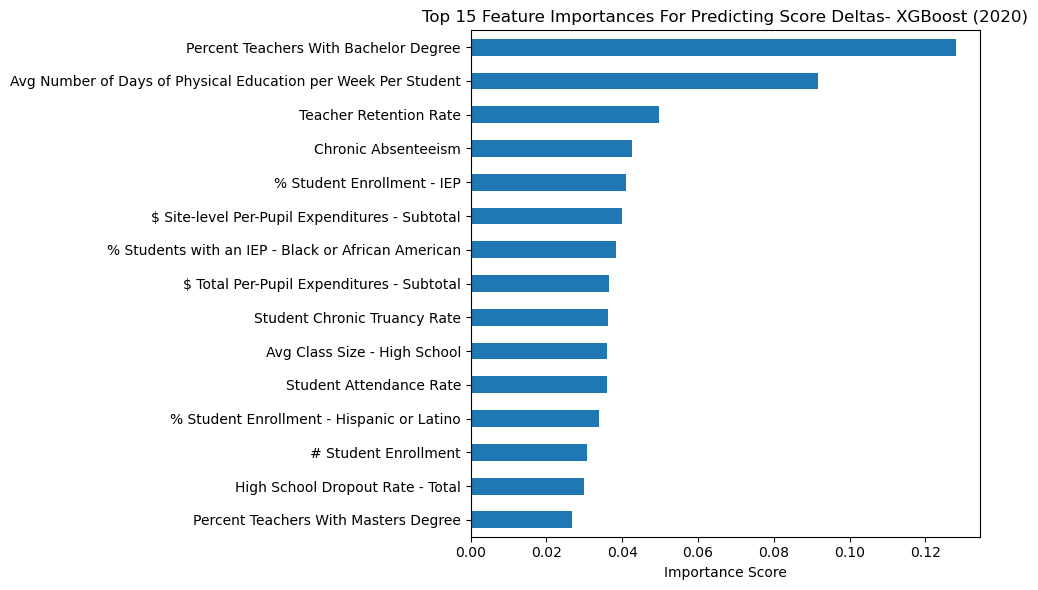

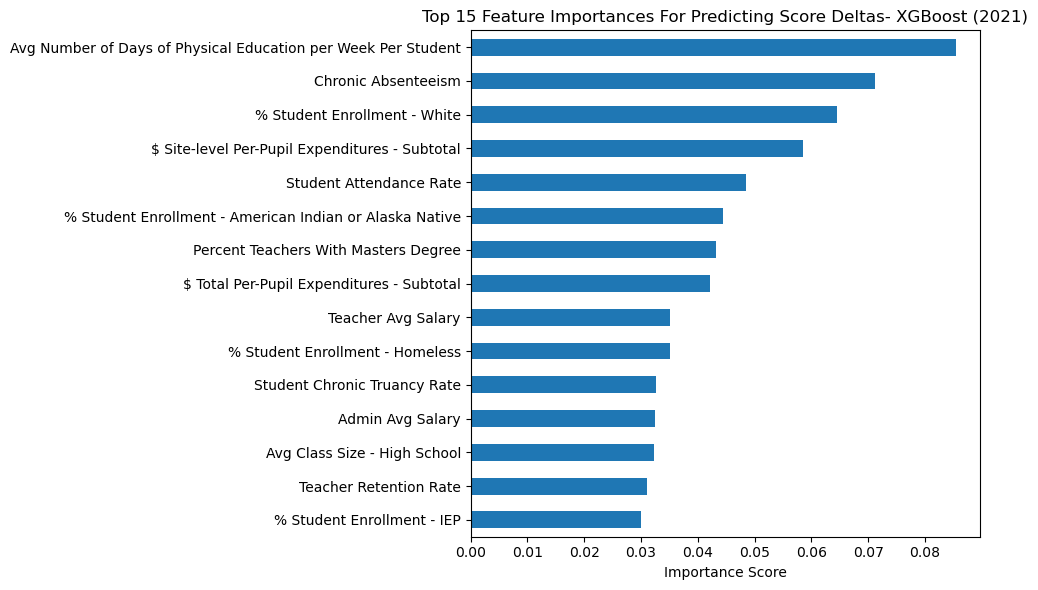

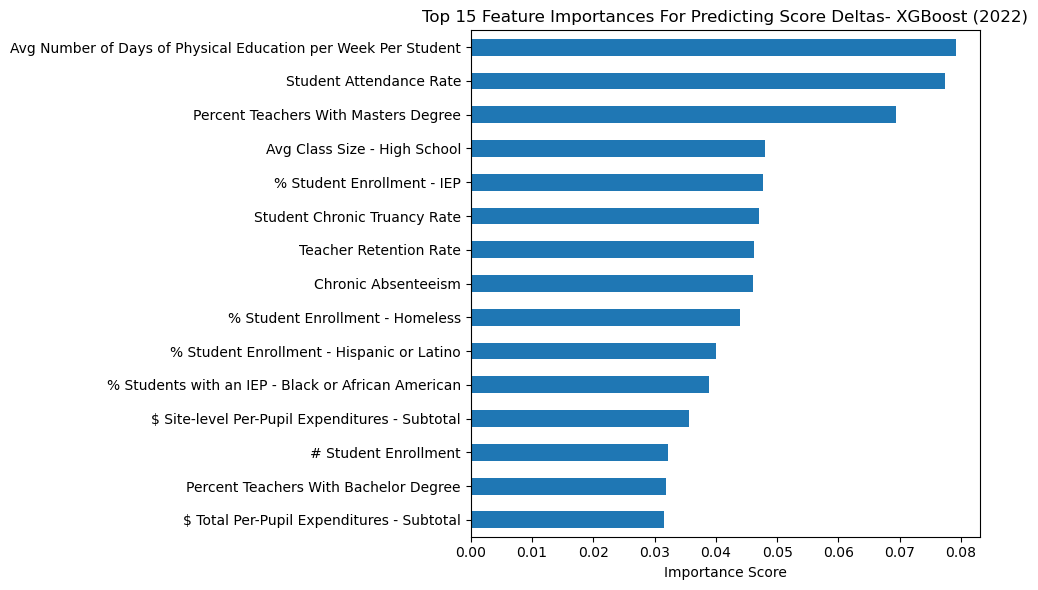

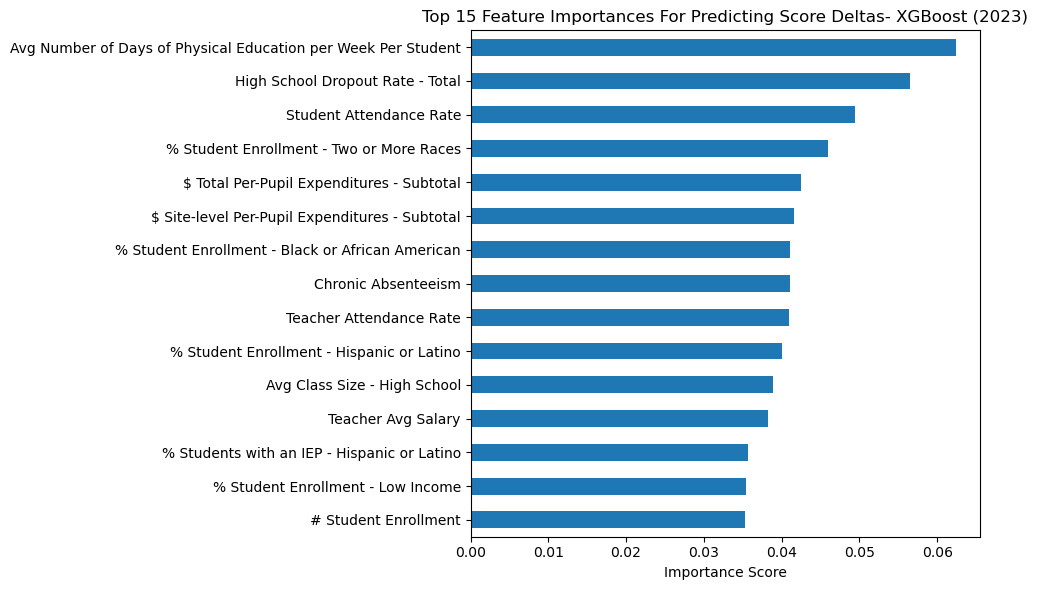

In [110]:
for year in [2020, 2021, 2022, 2023]:
    fig, ax = plt.subplots(figsize=(10, 6))
    delta_feature_importances_by_year[year].head(15).plot(kind='barh', ax=ax)
    ax.set_title(f'Top 15 Feature Importances For Predicting Score Deltas- XGBoost ({year})')
    ax.set_xlabel('Importance Score')
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()

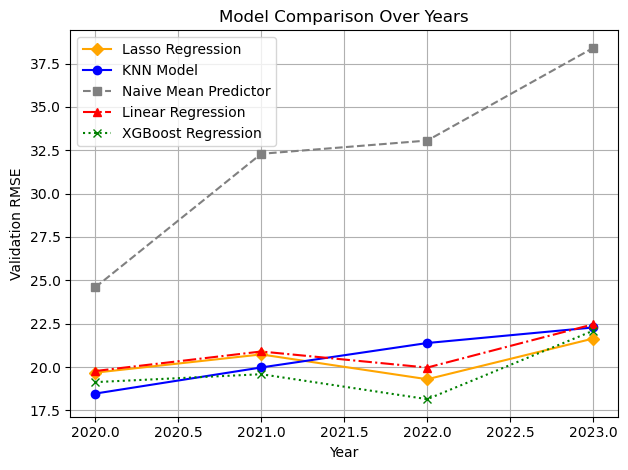

In [127]:
# # Plot Ridge RMSE
plt.plot([2020, 2021, 2022, 2023], delta_lasso_rmse, 
         marker='D', linestyle='-', color='orange', label='Lasso Regression')

# Plot the rest
plt.plot([ 2020, 2021, 2022, 2023], delta_KNN_RMSE, 
         marker='o', linestyle='-', color='b', label='KNN Model')

plt.plot([2020, 2021, 2022, 2023], delta_naive_RMSE, 
         marker='s', linestyle='--', color='gray', label='Naive Mean Predictor')

plt.plot([2020, 2021, 2022, 2023], delta_linreg_RMSE, 
         marker='^', linestyle='-.', color='r', label='Linear Regression')

plt.plot([2020, 2021, 2022, 2023], delta_xgb_rmse, 
         marker='x', linestyle=':', color='g', label='XGBoost Regression')

# Finalize plot
plt.xlabel("Year")
plt.ylabel("Validation RMSE")
plt.title("Model Comparison Over Years")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### How does the XGBoost model do on the *test* data set?

In [128]:
delta_xgb_rmse_test = []

for year in [2020, 2021, 2022, 2023]:
    X_test = splits_by_year[year]['X_test'][numerical_features]
    y_test = splits_by_year[year]['y_test']

    model = models_by_year[year]  # <-- Get the model trained on that year's data
    y_pred = model.predict(X_test)
    rmse = root_mean_squared_error(y_test, y_pred)
    delta_xgb_rmse_test.append(rmse)

print(delta_xgb_rmse_test)



[16.53456139167269, 21.142642485384684, 22.533397149798443, 22.047413870601158]


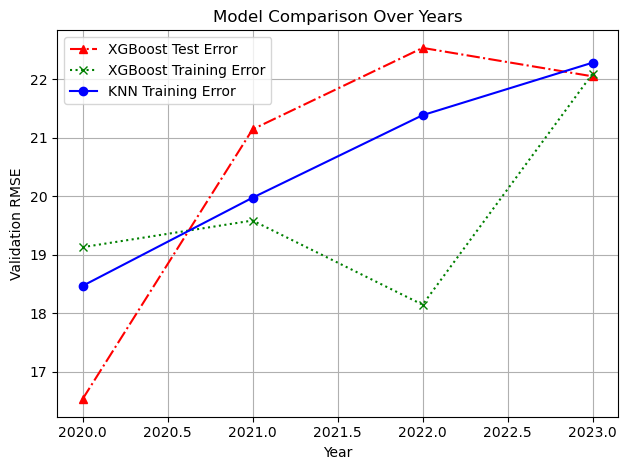

In [130]:
plt.plot([2020, 2021, 2022, 2023], delta_xgb_rmse_test, 
         marker='^', linestyle='-.', color='r', label='XGBoost Test Error')

plt.plot([2020, 2021, 2022, 2023], delta_xgb_rmse, 
         marker='x', linestyle=':', color='g', label='XGBoost Training Error')

# Plot the rest
plt.plot([ 2020, 2021, 2022, 2023], delta_KNN_RMSE, 
         marker='o', linestyle='-', color='b', label='KNN Training Error')
# Finalize plot
plt.xlabel("Year")
plt.ylabel("Validation RMSE")
plt.title("Model Comparison Over Years")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()